In [1]:
import pickle
import pandas as pd
import numpy as np

from bs4 import BeautifulSoup
import requests
from collections import defaultdict

import re
from datetime import datetime
import glob

In [2]:
#apt1 = 'https://www.cityrealty.com/nyc/midtown-east/milan-300-east-55th-street/apartment-9B/sold/A11864'
#apt2 = 'https://cityrealty.com/nyc/midtown-east/the-galleria-117-east-57th-street/apartment-27G/sold/A10573'
#r1 = requests.get(apt1)
#r2 = requests.get(apt2)
#s1 = BeautifulSoup(r1.text, "lxml")
#s2 = BeautifulSoup(r2.text, "lxml")

In [3]:
#soup.find_all('div', {"ng-if" : "column.type === 'priceChangeDate'"})
#soup.find_all('div', {"class" : "ng-scope'"})
#soup.find('div', {"class": "sold_info"}).find_all("span")[2].text
#soup.find('div', {"cr-results-table-row class": "row ng-scope x sold"})
#soup.find('div', {"class": "beds_baths"}).text.strip()

#soup.find('div', class_ = "key_details section").find("span", class_ = "value").text.strip()

#count = 0

#for tag in soup.find('div', class_ = "key_details section"):
#    try:
#        print(tag.text)
#        print(type(tag))
#        print(count)
#    except:
#        continue
    
    #print(type(tag))
    #print(tag)
    #print(count)
#    count = count + 1


#test = {}

#count = 0
#for row in soup.find_all('div', {"class" : "row"}):
#    for title in row.find_all("span", {"class": "title"}):
        #print(count)
        #print(title.text.strip())
        #count = count + 1
#        for value in row.find_all("span", {"class": "value"}):
            #print(count)
            #print(value.text.strip())
#            test[title.text.strip()] = value.text.strip()

In [30]:
# create dictionary from soup
def create_apt_dict(soup):

    apt_dict = {}

    # Full Name
    try:
        apt_dict['full_name'] = soup.find_all('h1', {"class" : "bld_title"})[0].text.strip()
    except:
        apt_dict['full_name'] = np.nan
    
    
    # Buidling Name
    try:
        apt_dict['bldg_name'] = soup.find_all('h1', {"class" : "bld_title"})[0].text.strip().split(",")[0].strip()
    except:
        apt_dict['bldg_name'] = np.nan
    
    
    # Building Address
    try:
        apt_dict['bldg_addr'] = soup.find_all('h1', {"class" : "bld_title"})[0].text.strip().split(",")[1].strip()
    except:
        apt_dict['bldg_addr'] = ""
    
    
    # Apt Floor
    try:
        apt_num = str(soup.find_all('h1', {"class" : "bld_title"})[0].text.strip().split(",")[2])
        apt_dict['apt_floor'] = int(re.findall('\d+', apt_num)[0])
    except:
        apt_dict['apt_floor'] = np.nan
        
    
    # Rating
    try:
        rating = str(soup.find_all('h1')[1].text.split("CityRealty Rating")[1])
        apt_dict['bldg_rating'] = int(re.findall('\d+', rating)[0])
    except:
        apt_dict['bldg_rating'] = np.nan


    # Sold day
    try:
        apt_dict['sold_date'] = soup.find('div', {"class": "brief"}).find("strong").text
    except:
        apt_dict['sold_date'] = ""
    
    
    # Sold day datetime
    try:
        day_dt = soup.find('div', {"class": "brief"}).find("strong").text
        apt_dict['sold_date_dt'] = datetime.strptime(day_dt.split('Last Sold on ')[1], "%b %d, %Y")
    except:
        apt_dict['sold_date_dt'] = np.nan


    # Sold Price
    try:
        apt_dict['sold_price'] = (float(soup
                                        .find('div', {"class": "sold_info"})
                                        .find_all("span")[2]
                                        .text.strip()[1:]
                                        .replace(",", "")))
    except:
        try:
            value = (soup
                     .find('div', {"class": "sold_info"})
                     .find_all("span")[0]
                     .text.strip()
                     .split("$",1)[1]
                     .split("(", 1)[0].strip())
            
            apt_dict['sold_price'] = float(value.replace(",", ""))
        except:
            apt_dict['sold_price'] = ""


    # Price Per Square Foot
    try:
        apt_dict['price_per_sqft'] = (float(soup
                                            .find('div', {"class": "sold_info"})
                                            .find_all("span")[3]
                                            .text
                                            .strip()
                                            .split("/", 1)[0]
                                            .strip()[2:]
                                            .replace(",", "")))
    except:
        try:
            apt_dict['price_per_sqft'] = (float(s1
                                                .find('div', {"class": "sold_info"})
                                                .find_all("span")[0]
                                                .text.strip()
                                                .split("(", 1)[1]
                                                .split("/", 1)[0]
                                                .strip()[1:]
                                                .replace(",", "")))
        except:    
            apt_dict['price_per_sqft'] = np.nan
          
        
    # Square Feet
    try:
        apt_dict['square_feet'] = round(apt_dict['sold_price'] / apt_dict['price_per_sqft'])
    except:
        apt_dict['square_feet'] = np.nan
    
    
    # Beds Baths
    try:
        apt_dict['bed_and_bath'] = soup.find('div', {"class": "beds_baths"}).text.strip()
    except:
        apt_dict['bed_and_bath'] = np.nan
    
    
    # Beds
    try:
        bed = soup.find('div', {"class": "beds_baths"}).text.strip().split(",")[0]
        apt_dict['beds'] = float(re.findall('\d+', bed)[0])
    except:
        apt_dict['beds'] = np.nan

        
    # Baths
    try:
        apt_dict['baths'] = (float(soup
                                   .find('div', {"class": "beds_baths"})
                                   .text.strip()
                                   .split(",")[1]
                                   .strip()
                                   .split(" ")[0]))
    except:
        apt_dict['baths'] = np.nan
        

    # Date Listed
    #try:
    #    date_listed = soup.find('div', class_ = "key_details section").find("span", class_ = "value").text.strip()
    #    apt_dict['date_listed'] = datetime.strptime(date_listed, "%b %d, %Y")
    #except:
    #    apt_dict['date_listed'] = ""


    # Table Data
    try:
        for row in soup.find_all('div', {"class" : "row"}):  # Look at each row in the div (entry in table)
            for title in row.find_all("span", {"class": "title"}):  # pull out the titles
                for value in row.find_all("span", {"class": "value"}): # pull out the values
                    apt_dict[title.text.strip()] = value.text.strip()
    except:
        None
    
    
    # Monthly Common Charges
    try:
        apt_dict['Monthly Common Charges'] = float(apt_dict['Monthly Common Charges'][1:].replace(",", ""))
    except:
        None
    
    
    # Monthly Taxes
    try:
        apt_dict['Monthly Real Estate Taxes'] = float(apt_dict['Monthly Real Estate Taxes'][1:].replace(",", ""))
    except:
        None
    
    
    # Minimum Down Payment
    try:
        apt_dict['Minimum Down Payment'] = float(apt_dict['Minimum Down Payment'].strip('%'))/100
    except:
        None
    
    
    # Date Listed
    try:
        apt_dict['Listed'] = datetime.strptime(apt_dict['Listed'], "%b %d, %Y")
    except:
        None
    
    return(apt_dict)


# grab files from directory and pull locations into a list
def get_files(folder_path):
    
    pickle_file_path = "{}/*.pkl".format(folder_path)
    file_list = glob.glob(pickle_file_path)
    
    return(file_list)


# create dataframe from html files
# uses function above -- create_apt_dict
def df_create(file_list):
    list_of_dict = []

    c = 0

    for file in file_list:
        print(file)

        # unpickle file
        with open(file, 'rb') as picklefile: 
            data = pickle.load(picklefile)

        # create beautiful soup
        soup = BeautifulSoup(data[0], "lxml")

        # create dictionary from soup
        apt_dict = create_apt_dict(soup)
        apt_dict['url'] = data[1]

        # append to list
        list_of_dict.append(apt_dict)

        print("# of Apts: ", str(c))
        c = c + 1
        
    df = pd.DataFrame(list_of_dict)
    return(df)

# Pulling the location of each file

In [31]:
file_list = get_files('/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump')
df = df_create(file_list)

/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1.pkl
# of Apts:  0
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10.pkl
# of Apts:  1
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_100.pkl
# of Apts:  2
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1000.pkl
# of Apts:  3
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10000.pkl
# of Apts:  4
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10001.pkl
# of Apts:  5
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10002.pkl
# of Apts:  6
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10003.pkl
# of Apts:  7
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10004.pkl
# of Apts:  8
/Users/JacK

# of Apts:  73
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10064.pkl
# of Apts:  74
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10065.pkl
# of Apts:  75
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10066.pkl
# of Apts:  76
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10067.pkl
# of Apts:  77
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10068.pkl
# of Apts:  78
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10069.pkl
# of Apts:  79
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1007.pkl
# of Apts:  80
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10070.pkl
# of Apts:  81
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_100

# of Apts:  146
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1013.pkl
# of Apts:  147
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10130.pkl
# of Apts:  148
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10131.pkl
# of Apts:  149
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10132.pkl
# of Apts:  150
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10133.pkl
# of Apts:  151
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10134.pkl
# of Apts:  152
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10135.pkl
# of Apts:  153
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10136.pkl
# of Apts:  154
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dum

# of Apts:  219
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10196.pkl
# of Apts:  220
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10197.pkl
# of Apts:  221
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10198.pkl
# of Apts:  222
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10199.pkl
# of Apts:  223
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_102.pkl
# of Apts:  224
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1020.pkl
# of Apts:  225
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10200.pkl
# of Apts:  226
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10201.pkl
# of Apts:  227
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/

# of Apts:  292
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10261.pkl
# of Apts:  293
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10262.pkl
# of Apts:  294
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10263.pkl
# of Apts:  295
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10264.pkl
# of Apts:  296
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10265.pkl
# of Apts:  297
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10266.pkl
# of Apts:  298
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10267.pkl
# of Apts:  299
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10268.pkl
# of Apts:  300
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_du

# of Apts:  365
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10327.pkl
# of Apts:  366
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10328.pkl
# of Apts:  367
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10329.pkl
# of Apts:  368
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1033.pkl
# of Apts:  369
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10330.pkl
# of Apts:  370
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10331.pkl
# of Apts:  371
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10332.pkl
# of Apts:  372
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10333.pkl
# of Apts:  373
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dum

# of Apts:  438
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10393.pkl
# of Apts:  439
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10394.pkl
# of Apts:  440
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10395.pkl
# of Apts:  441
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10396.pkl
# of Apts:  442
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10397.pkl
# of Apts:  443
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10398.pkl
# of Apts:  444
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10399.pkl
# of Apts:  445
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_104.pkl
# of Apts:  446
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump

# of Apts:  511
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10459.pkl
# of Apts:  512
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1046.pkl
# of Apts:  513
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10460.pkl
# of Apts:  514
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10461.pkl
# of Apts:  515
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10462.pkl
# of Apts:  516
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10463.pkl
# of Apts:  517
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10464.pkl
# of Apts:  518
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10465.pkl
# of Apts:  519
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dum

# of Apts:  584
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10524.pkl
# of Apts:  585
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10525.pkl
# of Apts:  586
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10526.pkl
# of Apts:  587
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10527.pkl
# of Apts:  588
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10528.pkl
# of Apts:  589
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10529.pkl
# of Apts:  590
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1053.pkl
# of Apts:  591
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10530.pkl
# of Apts:  592
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dum

# of Apts:  657
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10590.pkl
# of Apts:  658
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10591.pkl
# of Apts:  659
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10592.pkl
# of Apts:  660
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10593.pkl
# of Apts:  661
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10594.pkl
# of Apts:  662
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10595.pkl
# of Apts:  663
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10596.pkl
# of Apts:  664
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10597.pkl
# of Apts:  665
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_du

# of Apts:  730
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10656.pkl
# of Apts:  731
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10657.pkl
# of Apts:  732
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10658.pkl
# of Apts:  733
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10659.pkl
# of Apts:  734
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1066.pkl
# of Apts:  735
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10660.pkl
# of Apts:  736
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10661.pkl
# of Apts:  737
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10662.pkl
# of Apts:  738
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dum

# of Apts:  803
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10721.pkl
# of Apts:  804
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10722.pkl
# of Apts:  805
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10723.pkl
# of Apts:  806
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10724.pkl
# of Apts:  807
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10725.pkl
# of Apts:  808
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10726.pkl
# of Apts:  809
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10727.pkl
# of Apts:  810
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10728.pkl
# of Apts:  811
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_du

# of Apts:  876
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10788.pkl
# of Apts:  877
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10789.pkl
# of Apts:  878
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1079.pkl
# of Apts:  879
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10790.pkl
# of Apts:  880
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10791.pkl
# of Apts:  881
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10792.pkl
# of Apts:  882
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10793.pkl
# of Apts:  883
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10794.pkl
# of Apts:  884
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dum

# of Apts:  949
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10853.pkl
# of Apts:  950
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10854.pkl
# of Apts:  951
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10855.pkl
# of Apts:  952
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10856.pkl
# of Apts:  953
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10857.pkl
# of Apts:  954
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10858.pkl
# of Apts:  955
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10859.pkl
# of Apts:  956
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1086.pkl
# of Apts:  957
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dum

# of Apts:  1022
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10919.pkl
# of Apts:  1023
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1092.pkl
# of Apts:  1024
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10920.pkl
# of Apts:  1025
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10921.pkl
# of Apts:  1026
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10922.pkl
# of Apts:  1027
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10923.pkl
# of Apts:  1028
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10924.pkl
# of Apts:  1029
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10925.pkl
# of Apts:  1030
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  1094
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10984.pkl
# of Apts:  1095
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10985.pkl
# of Apts:  1096
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10986.pkl
# of Apts:  1097
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10987.pkl
# of Apts:  1098
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10988.pkl
# of Apts:  1099
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10989.pkl
# of Apts:  1100
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1099.pkl
# of Apts:  1101
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_10990.pkl
# of Apts:  1102
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  1166
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11048.pkl
# of Apts:  1167
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11049.pkl
# of Apts:  1168
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1105.pkl
# of Apts:  1169
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11050.pkl
# of Apts:  1170
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11051.pkl
# of Apts:  1171
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11052.pkl
# of Apts:  1172
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11053.pkl
# of Apts:  1173
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11054.pkl
# of Apts:  1174
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  1238
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11112.pkl
# of Apts:  1239
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11113.pkl
# of Apts:  1240
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11114.pkl
# of Apts:  1241
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11115.pkl
# of Apts:  1242
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11116.pkl
# of Apts:  1243
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11117.pkl
# of Apts:  1244
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11118.pkl
# of Apts:  1245
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11119.pkl
# of Apts:  1246
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  1310
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11178.pkl
# of Apts:  1311
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11179.pkl
# of Apts:  1312
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1118.pkl
# of Apts:  1313
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11180.pkl
# of Apts:  1314
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11181.pkl
# of Apts:  1315
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11182.pkl
# of Apts:  1316
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11183.pkl
# of Apts:  1317
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11184.pkl
# of Apts:  1318
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  1382
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11242.pkl
# of Apts:  1383
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11243.pkl
# of Apts:  1384
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11244.pkl
# of Apts:  1385
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11245.pkl
# of Apts:  1386
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11246.pkl
# of Apts:  1387
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11247.pkl
# of Apts:  1388
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11248.pkl
# of Apts:  1389
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11249.pkl
# of Apts:  1390
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  1454
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11307.pkl
# of Apts:  1455
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11308.pkl
# of Apts:  1456
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11309.pkl
# of Apts:  1457
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1131.pkl
# of Apts:  1458
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11310.pkl
# of Apts:  1459
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11311.pkl
# of Apts:  1460
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11312.pkl
# of Apts:  1461
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11313.pkl
# of Apts:  1462
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  1526
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11372.pkl
# of Apts:  1527
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11373.pkl
# of Apts:  1528
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11374.pkl
# of Apts:  1529
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11375.pkl
# of Apts:  1530
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11376.pkl
# of Apts:  1531
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11377.pkl
# of Apts:  1532
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11378.pkl
# of Apts:  1533
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11379.pkl
# of Apts:  1534
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  1598
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11437.pkl
# of Apts:  1599
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11438.pkl
# of Apts:  1600
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11439.pkl
# of Apts:  1601
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1144.pkl
# of Apts:  1602
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11440.pkl
# of Apts:  1603
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11441.pkl
# of Apts:  1604
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11442.pkl
# of Apts:  1605
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11443.pkl
# of Apts:  1606
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  1670
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11501.pkl
# of Apts:  1671
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11502.pkl
# of Apts:  1672
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11503.pkl
# of Apts:  1673
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11504.pkl
# of Apts:  1674
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11505.pkl
# of Apts:  1675
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11506.pkl
# of Apts:  1676
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11507.pkl
# of Apts:  1677
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11508.pkl
# of Apts:  1678
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  1742
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11567.pkl
# of Apts:  1743
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11568.pkl
# of Apts:  1744
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11569.pkl
# of Apts:  1745
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1157.pkl
# of Apts:  1746
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11570.pkl
# of Apts:  1747
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11571.pkl
# of Apts:  1748
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11572.pkl
# of Apts:  1749
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11573.pkl
# of Apts:  1750
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  1814
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11631.pkl
# of Apts:  1815
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11632.pkl
# of Apts:  1816
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11633.pkl
# of Apts:  1817
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11634.pkl
# of Apts:  1818
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11635.pkl
# of Apts:  1819
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11636.pkl
# of Apts:  1820
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11637.pkl
# of Apts:  1821
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11638.pkl
# of Apts:  1822
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  1886
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11697.pkl
# of Apts:  1887
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11698.pkl
# of Apts:  1888
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11699.pkl
# of Apts:  1889
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_117.pkl
# of Apts:  1890
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1170.pkl
# of Apts:  1891
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11700.pkl
# of Apts:  1892
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11701.pkl
# of Apts:  1893
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11702.pkl
# of Apts:  1894
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_d

# of Apts:  1958
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11761.pkl
# of Apts:  1959
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11762.pkl
# of Apts:  1960
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11763.pkl
# of Apts:  1961
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11764.pkl
# of Apts:  1962
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11765.pkl
# of Apts:  1963
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11766.pkl
# of Apts:  1964
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11767.pkl
# of Apts:  1965
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11768.pkl
# of Apts:  1966
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  2030
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11826.pkl
# of Apts:  2031
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11827.pkl
# of Apts:  2032
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11828.pkl
# of Apts:  2033
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11829.pkl
# of Apts:  2034
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1183.pkl
# of Apts:  2035
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11830.pkl
# of Apts:  2036
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11831.pkl
# of Apts:  2037
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11832.pkl
# of Apts:  2038
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  2102
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11891.pkl
# of Apts:  2103
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11892.pkl
# of Apts:  2104
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11893.pkl
# of Apts:  2105
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11894.pkl
# of Apts:  2106
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11895.pkl
# of Apts:  2107
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11896.pkl
# of Apts:  2108
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11897.pkl
# of Apts:  2109
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11898.pkl
# of Apts:  2110
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  2174
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11956.pkl
# of Apts:  2175
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11957.pkl
# of Apts:  2176
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11958.pkl
# of Apts:  2177
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11959.pkl
# of Apts:  2178
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1196.pkl
# of Apts:  2179
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11960.pkl
# of Apts:  2180
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11961.pkl
# of Apts:  2181
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_11962.pkl
# of Apts:  2182
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  2246
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1202.pkl
# of Apts:  2247
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12020.pkl
# of Apts:  2248
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12021.pkl
# of Apts:  2249
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12022.pkl
# of Apts:  2250
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12023.pkl
# of Apts:  2251
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12024.pkl
# of Apts:  2252
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12025.pkl
# of Apts:  2253
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12026.pkl
# of Apts:  2254
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  2318
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12085.pkl
# of Apts:  2319
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12086.pkl
# of Apts:  2320
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12087.pkl
# of Apts:  2321
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12088.pkl
# of Apts:  2322
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12089.pkl
# of Apts:  2323
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1209.pkl
# of Apts:  2324
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12090.pkl
# of Apts:  2325
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12091.pkl
# of Apts:  2326
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  2390
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1215.pkl
# of Apts:  2391
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12150.pkl
# of Apts:  2392
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12151.pkl
# of Apts:  2393
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12152.pkl
# of Apts:  2394
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12153.pkl
# of Apts:  2395
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12154.pkl
# of Apts:  2396
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12155.pkl
# of Apts:  2397
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12156.pkl
# of Apts:  2398
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  2462
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12214.pkl
# of Apts:  2463
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12215.pkl
# of Apts:  2464
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12216.pkl
# of Apts:  2465
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12217.pkl
# of Apts:  2466
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12218.pkl
# of Apts:  2467
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12219.pkl
# of Apts:  2468
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1222.pkl
# of Apts:  2469
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12220.pkl
# of Apts:  2470
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  2534
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1228.pkl
# of Apts:  2535
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12280.pkl
# of Apts:  2536
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12281.pkl
# of Apts:  2537
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12282.pkl
# of Apts:  2538
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12283.pkl
# of Apts:  2539
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12284.pkl
# of Apts:  2540
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12285.pkl
# of Apts:  2541
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12286.pkl
# of Apts:  2542
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  2606
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12344.pkl
# of Apts:  2607
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12345.pkl
# of Apts:  2608
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12346.pkl
# of Apts:  2609
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12347.pkl
# of Apts:  2610
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12348.pkl
# of Apts:  2611
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12349.pkl
# of Apts:  2612
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1235.pkl
# of Apts:  2613
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12350.pkl
# of Apts:  2614
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  2678
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12409.pkl
# of Apts:  2679
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1241.pkl
# of Apts:  2680
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12410.pkl
# of Apts:  2681
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12411.pkl
# of Apts:  2682
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12412.pkl
# of Apts:  2683
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12413.pkl
# of Apts:  2684
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12414.pkl
# of Apts:  2685
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12415.pkl
# of Apts:  2686
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  2750
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12474.pkl
# of Apts:  2751
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12475.pkl
# of Apts:  2752
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12476.pkl
# of Apts:  2753
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12477.pkl
# of Apts:  2754
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12478.pkl
# of Apts:  2755
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12479.pkl
# of Apts:  2756
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1248.pkl
# of Apts:  2757
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12480.pkl
# of Apts:  2758
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  2822
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12539.pkl
# of Apts:  2823
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1254.pkl
# of Apts:  2824
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12540.pkl
# of Apts:  2825
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12541.pkl
# of Apts:  2826
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12542.pkl
# of Apts:  2827
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12543.pkl
# of Apts:  2828
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12544.pkl
# of Apts:  2829
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12545.pkl
# of Apts:  2830
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  2894
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12603.pkl
# of Apts:  2895
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12604.pkl
# of Apts:  2896
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12605.pkl
# of Apts:  2897
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12606.pkl
# of Apts:  2898
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12607.pkl
# of Apts:  2899
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12608.pkl
# of Apts:  2900
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12609.pkl
# of Apts:  2901
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1261.pkl
# of Apts:  2902
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  2966
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12669.pkl
# of Apts:  2967
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1267.pkl
# of Apts:  2968
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12670.pkl
# of Apts:  2969
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12671.pkl
# of Apts:  2970
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12672.pkl
# of Apts:  2971
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12673.pkl
# of Apts:  2972
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12674.pkl
# of Apts:  2973
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12675.pkl
# of Apts:  2974
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  3038
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12733.pkl
# of Apts:  3039
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12734.pkl
# of Apts:  3040
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12735.pkl
# of Apts:  3041
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12736.pkl
# of Apts:  3042
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12737.pkl
# of Apts:  3043
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12738.pkl
# of Apts:  3044
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12739.pkl
# of Apts:  3045
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1274.pkl
# of Apts:  3046
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  3110
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12799.pkl
# of Apts:  3111
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_128.pkl
# of Apts:  3112
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1280.pkl
# of Apts:  3113
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12800.pkl
# of Apts:  3114
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12801.pkl
# of Apts:  3115
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12802.pkl
# of Apts:  3116
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12803.pkl
# of Apts:  3117
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12804.pkl
# of Apts:  3118
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_d

# of Apts:  3182
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12863.pkl
# of Apts:  3183
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12864.pkl
# of Apts:  3184
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12865.pkl
# of Apts:  3185
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12866.pkl
# of Apts:  3186
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12867.pkl
# of Apts:  3187
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12868.pkl
# of Apts:  3188
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12869.pkl
# of Apts:  3189
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1287.pkl
# of Apts:  3190
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  3254
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12928.pkl
# of Apts:  3255
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12929.pkl
# of Apts:  3256
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1293.pkl
# of Apts:  3257
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12930.pkl
# of Apts:  3258
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12931.pkl
# of Apts:  3259
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12932.pkl
# of Apts:  3260
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12933.pkl
# of Apts:  3261
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12934.pkl
# of Apts:  3262
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  3326
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12993.pkl
# of Apts:  3327
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12994.pkl
# of Apts:  3328
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12995.pkl
# of Apts:  3329
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12996.pkl
# of Apts:  3330
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12997.pkl
# of Apts:  3331
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12998.pkl
# of Apts:  3332
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_12999.pkl
# of Apts:  3333
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13.pkl
# of Apts:  3334
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_d

# of Apts:  3398
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13057.pkl
# of Apts:  3399
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13058.pkl
# of Apts:  3400
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13059.pkl
# of Apts:  3401
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1306.pkl
# of Apts:  3402
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13060.pkl
# of Apts:  3403
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13061.pkl
# of Apts:  3404
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13062.pkl
# of Apts:  3405
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13063.pkl
# of Apts:  3406
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  3470
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13121.pkl
# of Apts:  3471
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13122.pkl
# of Apts:  3472
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13123.pkl
# of Apts:  3473
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13124.pkl
# of Apts:  3474
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13125.pkl
# of Apts:  3475
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13126.pkl
# of Apts:  3476
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13127.pkl
# of Apts:  3477
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13128.pkl
# of Apts:  3478
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  3542
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13187.pkl
# of Apts:  3543
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13188.pkl
# of Apts:  3544
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13189.pkl
# of Apts:  3545
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1319.pkl
# of Apts:  3546
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13190.pkl
# of Apts:  3547
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13191.pkl
# of Apts:  3548
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13192.pkl
# of Apts:  3549
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13193.pkl
# of Apts:  3550
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  3614
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13251.pkl
# of Apts:  3615
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13252.pkl
# of Apts:  3616
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13253.pkl
# of Apts:  3617
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13254.pkl
# of Apts:  3618
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13255.pkl
# of Apts:  3619
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13256.pkl
# of Apts:  3620
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13257.pkl
# of Apts:  3621
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13258.pkl
# of Apts:  3622
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  3686
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13316.pkl
# of Apts:  3687
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13317.pkl
# of Apts:  3688
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13318.pkl
# of Apts:  3689
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13319.pkl
# of Apts:  3690
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1332.pkl
# of Apts:  3691
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13320.pkl
# of Apts:  3692
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13321.pkl
# of Apts:  3693
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13322.pkl
# of Apts:  3694
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  3758
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13381.pkl
# of Apts:  3759
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13382.pkl
# of Apts:  3760
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13383.pkl
# of Apts:  3761
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13384.pkl
# of Apts:  3762
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13385.pkl
# of Apts:  3763
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13386.pkl
# of Apts:  3764
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13387.pkl
# of Apts:  3765
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13388.pkl
# of Apts:  3766
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  3830
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13446.pkl
# of Apts:  3831
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13447.pkl
# of Apts:  3832
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13448.pkl
# of Apts:  3833
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13449.pkl
# of Apts:  3834
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1345.pkl
# of Apts:  3835
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13450.pkl
# of Apts:  3836
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13451.pkl
# of Apts:  3837
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13452.pkl
# of Apts:  3838
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  3902
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13510.pkl
# of Apts:  3903
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13511.pkl
# of Apts:  3904
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13512.pkl
# of Apts:  3905
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13513.pkl
# of Apts:  3906
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13514.pkl
# of Apts:  3907
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13515.pkl
# of Apts:  3908
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13516.pkl
# of Apts:  3909
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13517.pkl
# of Apts:  3910
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  3974
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13576.pkl
# of Apts:  3975
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13577.pkl
# of Apts:  3976
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13578.pkl
# of Apts:  3977
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13579.pkl
# of Apts:  3978
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1358.pkl
# of Apts:  3979
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13580.pkl
# of Apts:  3980
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13581.pkl
# of Apts:  3981
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13582.pkl
# of Apts:  3982
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  4046
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13640.pkl
# of Apts:  4047
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13641.pkl
# of Apts:  4048
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13642.pkl
# of Apts:  4049
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13643.pkl
# of Apts:  4050
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13644.pkl
# of Apts:  4051
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13645.pkl
# of Apts:  4052
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13646.pkl
# of Apts:  4053
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13647.pkl
# of Apts:  4054
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  4118
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13705.pkl
# of Apts:  4119
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13706.pkl
# of Apts:  4120
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13707.pkl
# of Apts:  4121
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13708.pkl
# of Apts:  4122
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13709.pkl
# of Apts:  4123
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1371.pkl
# of Apts:  4124
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13710.pkl
# of Apts:  4125
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13711.pkl
# of Apts:  4126
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13770.pkl
# of Apts:  4191
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13771.pkl
# of Apts:  4192
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13772.pkl
# of Apts:  4193
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13773.pkl
# of Apts:  4194
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13774.pkl
# of Apts:  4195
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13775.pkl
# of Apts:  4196
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13776.pkl
# of Apts:  4197
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13777.pkl
# of Apts:  4198
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1

# of Apts:  4263
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13836.pkl
# of Apts:  4264
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13837.pkl
# of Apts:  4265
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13838.pkl
# of Apts:  4266
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13839.pkl
# of Apts:  4267
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1384.pkl
# of Apts:  4268
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13840.pkl
# of Apts:  4269
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13841.pkl
# of Apts:  4270
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13842.pkl
# of Apts:  4271
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  4335
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13900.pkl
# of Apts:  4336
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13901.pkl
# of Apts:  4337
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13902.pkl
# of Apts:  4338
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13903.pkl
# of Apts:  4339
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13904.pkl
# of Apts:  4340
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13905.pkl
# of Apts:  4341
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13906.pkl
# of Apts:  4342
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13907.pkl
# of Apts:  4343
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  4407
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13966.pkl
# of Apts:  4408
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13967.pkl
# of Apts:  4409
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13968.pkl
# of Apts:  4410
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13969.pkl
# of Apts:  4411
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1397.pkl
# of Apts:  4412
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13970.pkl
# of Apts:  4413
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13971.pkl
# of Apts:  4414
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_13972.pkl
# of Apts:  4415
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  4479
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1403.pkl
# of Apts:  4480
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14030.pkl
# of Apts:  4481
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14031.pkl
# of Apts:  4482
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14032.pkl
# of Apts:  4483
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14033.pkl
# of Apts:  4484
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14034.pkl
# of Apts:  4485
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14035.pkl
# of Apts:  4486
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14036.pkl
# of Apts:  4487
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  4551
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14095.pkl
# of Apts:  4552
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14096.pkl
# of Apts:  4553
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14097.pkl
# of Apts:  4554
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14098.pkl
# of Apts:  4555
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14099.pkl
# of Apts:  4556
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_141.pkl
# of Apts:  4557
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1410.pkl
# of Apts:  4558
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14100.pkl
# of Apts:  4559
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_d

# of Apts:  4623
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1416.pkl
# of Apts:  4624
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14160.pkl
# of Apts:  4625
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14161.pkl
# of Apts:  4626
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14162.pkl
# of Apts:  4627
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14163.pkl
# of Apts:  4628
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14164.pkl
# of Apts:  4629
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14165.pkl
# of Apts:  4630
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14166.pkl
# of Apts:  4631
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  4695
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14224.pkl
# of Apts:  4696
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14225.pkl
# of Apts:  4697
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14226.pkl
# of Apts:  4698
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14227.pkl
# of Apts:  4699
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14228.pkl
# of Apts:  4700
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14229.pkl
# of Apts:  4701
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1423.pkl
# of Apts:  4702
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14230.pkl
# of Apts:  4703
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  4767
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1429.pkl
# of Apts:  4768
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14290.pkl
# of Apts:  4769
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14291.pkl
# of Apts:  4770
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14292.pkl
# of Apts:  4771
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14293.pkl
# of Apts:  4772
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14294.pkl
# of Apts:  4773
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14295.pkl
# of Apts:  4774
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14296.pkl
# of Apts:  4775
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  4839
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14354.pkl
# of Apts:  4840
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14355.pkl
# of Apts:  4841
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14356.pkl
# of Apts:  4842
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14357.pkl
# of Apts:  4843
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14358.pkl
# of Apts:  4844
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14359.pkl
# of Apts:  4845
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1436.pkl
# of Apts:  4846
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14360.pkl
# of Apts:  4847
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  4911
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14419.pkl
# of Apts:  4912
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1442.pkl
# of Apts:  4913
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14420.pkl
# of Apts:  4914
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14421.pkl
# of Apts:  4915
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14422.pkl
# of Apts:  4916
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14423.pkl
# of Apts:  4917
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14424.pkl
# of Apts:  4918
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14425.pkl
# of Apts:  4919
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  4983
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14484.pkl
# of Apts:  4984
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14485.pkl
# of Apts:  4985
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14486.pkl
# of Apts:  4986
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14487.pkl
# of Apts:  4987
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14488.pkl
# of Apts:  4988
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14489.pkl
# of Apts:  4989
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1449.pkl
# of Apts:  4990
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14490.pkl
# of Apts:  4991
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  5055
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14549.pkl
# of Apts:  5056
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1455.pkl
# of Apts:  5057
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14550.pkl
# of Apts:  5058
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14551.pkl
# of Apts:  5059
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14552.pkl
# of Apts:  5060
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14553.pkl
# of Apts:  5061
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14554.pkl
# of Apts:  5062
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14555.pkl
# of Apts:  5063
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  5127
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14613.pkl
# of Apts:  5128
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14614.pkl
# of Apts:  5129
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14615.pkl
# of Apts:  5130
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14616.pkl
# of Apts:  5131
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14617.pkl
# of Apts:  5132
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14618.pkl
# of Apts:  5133
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14619.pkl
# of Apts:  5134
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1462.pkl
# of Apts:  5135
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  5199
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14679.pkl
# of Apts:  5200
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1468.pkl
# of Apts:  5201
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14680.pkl
# of Apts:  5202
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14681.pkl
# of Apts:  5203
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14682.pkl
# of Apts:  5204
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14683.pkl
# of Apts:  5205
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14684.pkl
# of Apts:  5206
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14685.pkl
# of Apts:  5207
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  5271
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14743.pkl
# of Apts:  5272
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14744.pkl
# of Apts:  5273
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14745.pkl
# of Apts:  5274
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14746.pkl
# of Apts:  5275
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14747.pkl
# of Apts:  5276
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14748.pkl
# of Apts:  5277
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14749.pkl
# of Apts:  5278
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1475.pkl
# of Apts:  5279
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  5343
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14808.pkl
# of Apts:  5344
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14809.pkl
# of Apts:  5345
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1481.pkl
# of Apts:  5346
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14810.pkl
# of Apts:  5347
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14811.pkl
# of Apts:  5348
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14812.pkl
# of Apts:  5349
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14813.pkl
# of Apts:  5350
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14814.pkl
# of Apts:  5351
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  5415
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14873.pkl
# of Apts:  5416
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14874.pkl
# of Apts:  5417
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14875.pkl
# of Apts:  5418
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14876.pkl
# of Apts:  5419
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14877.pkl
# of Apts:  5420
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14878.pkl
# of Apts:  5421
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14879.pkl
# of Apts:  5422
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1488.pkl
# of Apts:  5423
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  5487
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14938.pkl
# of Apts:  5488
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14939.pkl
# of Apts:  5489
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1494.pkl
# of Apts:  5490
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14940.pkl
# of Apts:  5491
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14941.pkl
# of Apts:  5492
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14942.pkl
# of Apts:  5493
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14943.pkl
# of Apts:  5494
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_14944.pkl
# of Apts:  5495
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  5559
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15001.pkl
# of Apts:  5560
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15002.pkl
# of Apts:  5561
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15003.pkl
# of Apts:  5562
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15004.pkl
# of Apts:  5563
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15005.pkl
# of Apts:  5564
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15006.pkl
# of Apts:  5565
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15007.pkl
# of Apts:  5566
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15008.pkl
# of Apts:  5567
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  5631
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15067.pkl
# of Apts:  5632
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15068.pkl
# of Apts:  5633
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15069.pkl
# of Apts:  5634
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1507.pkl
# of Apts:  5635
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15070.pkl
# of Apts:  5636
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15071.pkl
# of Apts:  5637
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15072.pkl
# of Apts:  5638
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15073.pkl
# of Apts:  5639
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  5703
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15131.pkl
# of Apts:  5704
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15132.pkl
# of Apts:  5705
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15133.pkl
# of Apts:  5706
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15134.pkl
# of Apts:  5707
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15135.pkl
# of Apts:  5708
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15136.pkl
# of Apts:  5709
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15137.pkl
# of Apts:  5710
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15138.pkl
# of Apts:  5711
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  5775
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15197.pkl
# of Apts:  5776
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15198.pkl
# of Apts:  5777
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15199.pkl
# of Apts:  5778
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_152.pkl
# of Apts:  5779
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1520.pkl
# of Apts:  5780
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15200.pkl
# of Apts:  5781
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15201.pkl
# of Apts:  5782
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15202.pkl
# of Apts:  5783
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_d

# of Apts:  5847
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15261.pkl
# of Apts:  5848
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15262.pkl
# of Apts:  5849
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15263.pkl
# of Apts:  5850
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15264.pkl
# of Apts:  5851
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15265.pkl
# of Apts:  5852
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15266.pkl
# of Apts:  5853
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15267.pkl
# of Apts:  5854
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15268.pkl
# of Apts:  5855
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  5919
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15326.pkl
# of Apts:  5920
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15327.pkl
# of Apts:  5921
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15328.pkl
# of Apts:  5922
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15329.pkl
# of Apts:  5923
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1533.pkl
# of Apts:  5924
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15330.pkl
# of Apts:  5925
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15331.pkl
# of Apts:  5926
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15332.pkl
# of Apts:  5927
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  5991
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15391.pkl
# of Apts:  5992
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15392.pkl
# of Apts:  5993
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15393.pkl
# of Apts:  5994
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15394.pkl
# of Apts:  5995
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15395.pkl
# of Apts:  5996
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15396.pkl
# of Apts:  5997
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15397.pkl
# of Apts:  5998
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15398.pkl
# of Apts:  5999
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  6063
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15456.pkl
# of Apts:  6064
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15457.pkl
# of Apts:  6065
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15458.pkl
# of Apts:  6066
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15459.pkl
# of Apts:  6067
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1546.pkl
# of Apts:  6068
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15460.pkl
# of Apts:  6069
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15461.pkl
# of Apts:  6070
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15462.pkl
# of Apts:  6071
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  6135
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15520.pkl
# of Apts:  6136
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15521.pkl
# of Apts:  6137
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15522.pkl
# of Apts:  6138
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15523.pkl
# of Apts:  6139
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15524.pkl
# of Apts:  6140
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15525.pkl
# of Apts:  6141
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15526.pkl
# of Apts:  6142
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15527.pkl
# of Apts:  6143
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  6207
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15586.pkl
# of Apts:  6208
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15587.pkl
# of Apts:  6209
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15588.pkl
# of Apts:  6210
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15589.pkl
# of Apts:  6211
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1559.pkl
# of Apts:  6212
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15590.pkl
# of Apts:  6213
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15591.pkl
# of Apts:  6214
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15592.pkl
# of Apts:  6215
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  6279
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15650.pkl
# of Apts:  6280
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15651.pkl
# of Apts:  6281
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15652.pkl
# of Apts:  6282
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15653.pkl
# of Apts:  6283
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15654.pkl
# of Apts:  6284
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15655.pkl
# of Apts:  6285
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15656.pkl
# of Apts:  6286
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15657.pkl
# of Apts:  6287
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  6351
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15715.pkl
# of Apts:  6352
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15716.pkl
# of Apts:  6353
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15717.pkl
# of Apts:  6354
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15718.pkl
# of Apts:  6355
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15719.pkl
# of Apts:  6356
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1572.pkl
# of Apts:  6357
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15720.pkl
# of Apts:  6358
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15721.pkl
# of Apts:  6359
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  6423
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15780.pkl
# of Apts:  6424
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15781.pkl
# of Apts:  6425
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15782.pkl
# of Apts:  6426
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15783.pkl
# of Apts:  6427
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15784.pkl
# of Apts:  6428
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15785.pkl
# of Apts:  6429
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15786.pkl
# of Apts:  6430
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15787.pkl
# of Apts:  6431
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  6495
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15845.pkl
# of Apts:  6496
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15846.pkl
# of Apts:  6497
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15847.pkl
# of Apts:  6498
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15848.pkl
# of Apts:  6499
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15849.pkl
# of Apts:  6500
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1585.pkl
# of Apts:  6501
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15850.pkl
# of Apts:  6502
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15851.pkl
# of Apts:  6503
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  6567
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1591.pkl
# of Apts:  6568
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15910.pkl
# of Apts:  6569
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15911.pkl
# of Apts:  6570
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15912.pkl
# of Apts:  6571
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15913.pkl
# of Apts:  6572
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15914.pkl
# of Apts:  6573
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15915.pkl
# of Apts:  6574
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15916.pkl
# of Apts:  6575
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  6639
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15975.pkl
# of Apts:  6640
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15976.pkl
# of Apts:  6641
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15977.pkl
# of Apts:  6642
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15978.pkl
# of Apts:  6643
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15979.pkl
# of Apts:  6644
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1598.pkl
# of Apts:  6645
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15980.pkl
# of Apts:  6646
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_15981.pkl
# of Apts:  6647
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  6711
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16039.pkl
# of Apts:  6712
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1604.pkl
# of Apts:  6713
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16040.pkl
# of Apts:  6714
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16041.pkl
# of Apts:  6715
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16042.pkl
# of Apts:  6716
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16043.pkl
# of Apts:  6717
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16044.pkl
# of Apts:  6718
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16045.pkl
# of Apts:  6719
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  6783
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16103.pkl
# of Apts:  6784
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16104.pkl
# of Apts:  6785
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16105.pkl
# of Apts:  6786
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16106.pkl
# of Apts:  6787
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16107.pkl
# of Apts:  6788
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16108.pkl
# of Apts:  6789
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16109.pkl
# of Apts:  6790
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1611.pkl
# of Apts:  6791
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  6855
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16169.pkl
# of Apts:  6856
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1617.pkl
# of Apts:  6857
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16170.pkl
# of Apts:  6858
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16171.pkl
# of Apts:  6859
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16172.pkl
# of Apts:  6860
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16173.pkl
# of Apts:  6861
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16174.pkl
# of Apts:  6862
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16175.pkl
# of Apts:  6863
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  6927
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16233.pkl
# of Apts:  6928
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16234.pkl
# of Apts:  6929
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16235.pkl
# of Apts:  6930
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16236.pkl
# of Apts:  6931
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16237.pkl
# of Apts:  6932
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16238.pkl
# of Apts:  6933
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16239.pkl
# of Apts:  6934
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1624.pkl
# of Apts:  6935
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  6999
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16299.pkl
# of Apts:  7000
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_163.pkl
# of Apts:  7001
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1630.pkl
# of Apts:  7002
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16300.pkl
# of Apts:  7003
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16301.pkl
# of Apts:  7004
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16302.pkl
# of Apts:  7005
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16303.pkl
# of Apts:  7006
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16304.pkl
# of Apts:  7007
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_d

# of Apts:  7071
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16363.pkl
# of Apts:  7072
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16364.pkl
# of Apts:  7073
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16365.pkl
# of Apts:  7074
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16366.pkl
# of Apts:  7075
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16367.pkl
# of Apts:  7076
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16368.pkl
# of Apts:  7077
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16369.pkl
# of Apts:  7078
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1637.pkl
# of Apts:  7079
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  7143
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16428.pkl
# of Apts:  7144
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16429.pkl
# of Apts:  7145
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1643.pkl
# of Apts:  7146
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16430.pkl
# of Apts:  7147
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16431.pkl
# of Apts:  7148
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16432.pkl
# of Apts:  7149
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16433.pkl
# of Apts:  7150
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16434.pkl
# of Apts:  7151
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  7215
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16493.pkl
# of Apts:  7216
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16494.pkl
# of Apts:  7217
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16495.pkl
# of Apts:  7218
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16496.pkl
# of Apts:  7219
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16497.pkl
# of Apts:  7220
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16498.pkl
# of Apts:  7221
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16499.pkl
# of Apts:  7222
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_165.pkl
# of Apts:  7223
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_

# of Apts:  7287
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16558.pkl
# of Apts:  7288
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16559.pkl
# of Apts:  7289
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1656.pkl
# of Apts:  7290
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16560.pkl
# of Apts:  7291
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16561.pkl
# of Apts:  7292
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16562.pkl
# of Apts:  7293
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16563.pkl
# of Apts:  7294
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16564.pkl
# of Apts:  7295
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  7359
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16622.pkl
# of Apts:  7360
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16623.pkl
# of Apts:  7361
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16624.pkl
# of Apts:  7362
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16625.pkl
# of Apts:  7363
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16626.pkl
# of Apts:  7364
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16627.pkl
# of Apts:  7365
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16628.pkl
# of Apts:  7366
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16629.pkl
# of Apts:  7367
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  7431
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16688.pkl
# of Apts:  7432
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16689.pkl
# of Apts:  7433
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1669.pkl
# of Apts:  7434
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16690.pkl
# of Apts:  7435
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16691.pkl
# of Apts:  7436
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16692.pkl
# of Apts:  7437
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16693.pkl
# of Apts:  7438
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16694.pkl
# of Apts:  7439
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  7503
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16752.pkl
# of Apts:  7504
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16753.pkl
# of Apts:  7505
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16754.pkl
# of Apts:  7506
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16755.pkl
# of Apts:  7507
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16756.pkl
# of Apts:  7508
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16757.pkl
# of Apts:  7509
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16758.pkl
# of Apts:  7510
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16759.pkl
# of Apts:  7511
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  7575
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16817.pkl
# of Apts:  7576
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16818.pkl
# of Apts:  7577
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16819.pkl
# of Apts:  7578
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1682.pkl
# of Apts:  7579
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16820.pkl
# of Apts:  7580
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16821.pkl
# of Apts:  7581
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16822.pkl
# of Apts:  7582
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16823.pkl
# of Apts:  7583
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  7647
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16882.pkl
# of Apts:  7648
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16883.pkl
# of Apts:  7649
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16884.pkl
# of Apts:  7650
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16885.pkl
# of Apts:  7651
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16886.pkl
# of Apts:  7652
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16887.pkl
# of Apts:  7653
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16888.pkl
# of Apts:  7654
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16889.pkl
# of Apts:  7655
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  7719
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16947.pkl
# of Apts:  7720
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16948.pkl
# of Apts:  7721
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16949.pkl
# of Apts:  7722
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1695.pkl
# of Apts:  7723
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16950.pkl
# of Apts:  7724
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16951.pkl
# of Apts:  7725
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16952.pkl
# of Apts:  7726
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_16953.pkl
# of Apts:  7727
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  7791
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17010.pkl
# of Apts:  7792
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17011.pkl
# of Apts:  7793
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17012.pkl
# of Apts:  7794
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17013.pkl
# of Apts:  7795
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17014.pkl
# of Apts:  7796
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17015.pkl
# of Apts:  7797
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17016.pkl
# of Apts:  7798
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17017.pkl
# of Apts:  7799
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  7863
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17076.pkl
# of Apts:  7864
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17077.pkl
# of Apts:  7865
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17078.pkl
# of Apts:  7866
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17079.pkl
# of Apts:  7867
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1708.pkl
# of Apts:  7868
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17080.pkl
# of Apts:  7869
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17081.pkl
# of Apts:  7870
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17082.pkl
# of Apts:  7871
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  7935
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17140.pkl
# of Apts:  7936
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17141.pkl
# of Apts:  7937
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17142.pkl
# of Apts:  7938
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17143.pkl
# of Apts:  7939
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17144.pkl
# of Apts:  7940
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17145.pkl
# of Apts:  7941
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17146.pkl
# of Apts:  7942
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17147.pkl
# of Apts:  7943
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  8007
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17205.pkl
# of Apts:  8008
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17206.pkl
# of Apts:  8009
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17207.pkl
# of Apts:  8010
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17208.pkl
# of Apts:  8011
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17209.pkl
# of Apts:  8012
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1721.pkl
# of Apts:  8013
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17210.pkl
# of Apts:  8014
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17211.pkl
# of Apts:  8015
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  8079
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17270.pkl
# of Apts:  8080
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17271.pkl
# of Apts:  8081
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17272.pkl
# of Apts:  8082
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17273.pkl
# of Apts:  8083
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17274.pkl
# of Apts:  8084
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17275.pkl
# of Apts:  8085
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17276.pkl
# of Apts:  8086
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17277.pkl
# of Apts:  8087
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  8151
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17335.pkl
# of Apts:  8152
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17336.pkl
# of Apts:  8153
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17337.pkl
# of Apts:  8154
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17338.pkl
# of Apts:  8155
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17339.pkl
# of Apts:  8156
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1734.pkl
# of Apts:  8157
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17340.pkl
# of Apts:  8158
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17341.pkl
# of Apts:  8159
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  8223
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1740.pkl
# of Apts:  8224
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17400.pkl
# of Apts:  8225
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17401.pkl
# of Apts:  8226
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17402.pkl
# of Apts:  8227
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17403.pkl
# of Apts:  8228
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17404.pkl
# of Apts:  8229
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17405.pkl
# of Apts:  8230
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17406.pkl
# of Apts:  8231
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  8295
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17465.pkl
# of Apts:  8296
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17466.pkl
# of Apts:  8297
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17467.pkl
# of Apts:  8298
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17468.pkl
# of Apts:  8299
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17469.pkl
# of Apts:  8300
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1747.pkl
# of Apts:  8301
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17470.pkl
# of Apts:  8302
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17471.pkl
# of Apts:  8303
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  8367
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1753.pkl
# of Apts:  8368
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17530.pkl
# of Apts:  8369
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17531.pkl
# of Apts:  8370
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17532.pkl
# of Apts:  8371
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17533.pkl
# of Apts:  8372
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17534.pkl
# of Apts:  8373
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17535.pkl
# of Apts:  8374
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17536.pkl
# of Apts:  8375
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  8439
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17595.pkl
# of Apts:  8440
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17596.pkl
# of Apts:  8441
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17597.pkl
# of Apts:  8442
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17598.pkl
# of Apts:  8443
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17599.pkl
# of Apts:  8444
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_176.pkl
# of Apts:  8445
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1760.pkl
# of Apts:  8446
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17600.pkl
# of Apts:  8447
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_d

# of Apts:  8511
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1766.pkl
# of Apts:  8512
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17660.pkl
# of Apts:  8513
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17661.pkl
# of Apts:  8514
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17662.pkl
# of Apts:  8515
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17663.pkl
# of Apts:  8516
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17664.pkl
# of Apts:  8517
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17665.pkl
# of Apts:  8518
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17666.pkl
# of Apts:  8519
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  8583
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17724.pkl
# of Apts:  8584
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17725.pkl
# of Apts:  8585
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17726.pkl
# of Apts:  8586
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17727.pkl
# of Apts:  8587
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17728.pkl
# of Apts:  8588
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17729.pkl
# of Apts:  8589
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1773.pkl
# of Apts:  8590
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17730.pkl
# of Apts:  8591
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  8655
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1779.pkl
# of Apts:  8656
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17790.pkl
# of Apts:  8657
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17791.pkl
# of Apts:  8658
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17792.pkl
# of Apts:  8659
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17793.pkl
# of Apts:  8660
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17794.pkl
# of Apts:  8661
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17795.pkl
# of Apts:  8662
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17796.pkl
# of Apts:  8663
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  8727
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17854.pkl
# of Apts:  8728
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17855.pkl
# of Apts:  8729
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17856.pkl
# of Apts:  8730
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17857.pkl
# of Apts:  8731
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17858.pkl
# of Apts:  8732
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17859.pkl
# of Apts:  8733
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1786.pkl
# of Apts:  8734
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17860.pkl
# of Apts:  8735
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  8799
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17919.pkl
# of Apts:  8800
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1792.pkl
# of Apts:  8801
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17920.pkl
# of Apts:  8802
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17921.pkl
# of Apts:  8803
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17922.pkl
# of Apts:  8804
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17923.pkl
# of Apts:  8805
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17924.pkl
# of Apts:  8806
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17925.pkl
# of Apts:  8807
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  8871
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17984.pkl
# of Apts:  8872
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17985.pkl
# of Apts:  8873
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17986.pkl
# of Apts:  8874
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17987.pkl
# of Apts:  8875
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17988.pkl
# of Apts:  8876
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17989.pkl
# of Apts:  8877
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1799.pkl
# of Apts:  8878
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_17990.pkl
# of Apts:  8879
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  8943
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18048.pkl
# of Apts:  8944
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18049.pkl
# of Apts:  8945
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1805.pkl
# of Apts:  8946
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18050.pkl
# of Apts:  8947
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18051.pkl
# of Apts:  8948
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18052.pkl
# of Apts:  8949
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18053.pkl
# of Apts:  8950
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18054.pkl
# of Apts:  8951
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  9015
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18112.pkl
# of Apts:  9016
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18113.pkl
# of Apts:  9017
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18114.pkl
# of Apts:  9018
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18115.pkl
# of Apts:  9019
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18116.pkl
# of Apts:  9020
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18117.pkl
# of Apts:  9021
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18118.pkl
# of Apts:  9022
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18119.pkl
# of Apts:  9023
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  9087
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18178.pkl
# of Apts:  9088
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18179.pkl
# of Apts:  9089
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1818.pkl
# of Apts:  9090
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18180.pkl
# of Apts:  9091
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18181.pkl
# of Apts:  9092
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18182.pkl
# of Apts:  9093
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18183.pkl
# of Apts:  9094
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18184.pkl
# of Apts:  9095
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  9159
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18242.pkl
# of Apts:  9160
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18243.pkl
# of Apts:  9161
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18244.pkl
# of Apts:  9162
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18245.pkl
# of Apts:  9163
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18246.pkl
# of Apts:  9164
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18247.pkl
# of Apts:  9165
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18248.pkl
# of Apts:  9166
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18249.pkl
# of Apts:  9167
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  9231
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18307.pkl
# of Apts:  9232
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18308.pkl
# of Apts:  9233
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18309.pkl
# of Apts:  9234
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1831.pkl
# of Apts:  9235
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18310.pkl
# of Apts:  9236
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18311.pkl
# of Apts:  9237
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18312.pkl
# of Apts:  9238
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18313.pkl
# of Apts:  9239
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  9303
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18372.pkl
# of Apts:  9304
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18373.pkl
# of Apts:  9305
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18374.pkl
# of Apts:  9306
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18375.pkl
# of Apts:  9307
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18376.pkl
# of Apts:  9308
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18377.pkl
# of Apts:  9309
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18378.pkl
# of Apts:  9310
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18379.pkl
# of Apts:  9311
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  9375
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18437.pkl
# of Apts:  9376
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18438.pkl
# of Apts:  9377
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18439.pkl
# of Apts:  9378
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1844.pkl
# of Apts:  9379
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18440.pkl
# of Apts:  9380
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18441.pkl
# of Apts:  9381
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18442.pkl
# of Apts:  9382
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18443.pkl
# of Apts:  9383
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  9447
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18501.pkl
# of Apts:  9448
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18502.pkl
# of Apts:  9449
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18503.pkl
# of Apts:  9450
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18504.pkl
# of Apts:  9451
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18505.pkl
# of Apts:  9452
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18506.pkl
# of Apts:  9453
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18507.pkl
# of Apts:  9454
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18508.pkl
# of Apts:  9455
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  9519
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18567.pkl
# of Apts:  9520
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18568.pkl
# of Apts:  9521
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18569.pkl
# of Apts:  9522
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1857.pkl
# of Apts:  9523
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18570.pkl
# of Apts:  9524
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18571.pkl
# of Apts:  9525
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18572.pkl
# of Apts:  9526
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18573.pkl
# of Apts:  9527
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  9591
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18631.pkl
# of Apts:  9592
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18632.pkl
# of Apts:  9593
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18633.pkl
# of Apts:  9594
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18634.pkl
# of Apts:  9595
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18635.pkl
# of Apts:  9596
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18636.pkl
# of Apts:  9597
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18637.pkl
# of Apts:  9598
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18638.pkl
# of Apts:  9599
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  9663
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18697.pkl
# of Apts:  9664
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18698.pkl
# of Apts:  9665
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18699.pkl
# of Apts:  9666
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_187.pkl
# of Apts:  9667
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1870.pkl
# of Apts:  9668
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18700.pkl
# of Apts:  9669
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18701.pkl
# of Apts:  9670
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18702.pkl
# of Apts:  9671
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_d

# of Apts:  9735
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18761.pkl
# of Apts:  9736
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18762.pkl
# of Apts:  9737
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18763.pkl
# of Apts:  9738
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18764.pkl
# of Apts:  9739
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18765.pkl
# of Apts:  9740
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18766.pkl
# of Apts:  9741
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18767.pkl
# of Apts:  9742
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18768.pkl
# of Apts:  9743
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  9807
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18826.pkl
# of Apts:  9808
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18827.pkl
# of Apts:  9809
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18828.pkl
# of Apts:  9810
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18829.pkl
# of Apts:  9811
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1883.pkl
# of Apts:  9812
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18830.pkl
# of Apts:  9813
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18831.pkl
# of Apts:  9814
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18832.pkl
# of Apts:  9815
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  9879
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18891.pkl
# of Apts:  9880
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18892.pkl
# of Apts:  9881
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18893.pkl
# of Apts:  9882
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18894.pkl
# of Apts:  9883
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18895.pkl
# of Apts:  9884
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18896.pkl
# of Apts:  9885
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18897.pkl
# of Apts:  9886
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18898.pkl
# of Apts:  9887
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  9951
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18956.pkl
# of Apts:  9952
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18957.pkl
# of Apts:  9953
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18958.pkl
# of Apts:  9954
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18959.pkl
# of Apts:  9955
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1896.pkl
# of Apts:  9956
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18960.pkl
# of Apts:  9957
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18961.pkl
# of Apts:  9958
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_18962.pkl
# of Apts:  9959
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  10023
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1902.pkl
# of Apts:  10024
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19020.pkl
# of Apts:  10025
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19021.pkl
# of Apts:  10026
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19022.pkl
# of Apts:  10027
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19023.pkl
# of Apts:  10028
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19024.pkl
# of Apts:  10029
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19025.pkl
# of Apts:  10030
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19026.pkl
# of Apts:  10031
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealt

# of Apts:  10095
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19085.pkl
# of Apts:  10096
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19086.pkl
# of Apts:  10097
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19087.pkl
# of Apts:  10098
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19088.pkl
# of Apts:  10099
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19089.pkl
# of Apts:  10100
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1909.pkl
# of Apts:  10101
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19090.pkl
# of Apts:  10102
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19091.pkl
# of Apts:  10103
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealt

# of Apts:  10167
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1915.pkl
# of Apts:  10168
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19150.pkl
# of Apts:  10169
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19151.pkl
# of Apts:  10170
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19152.pkl
# of Apts:  10171
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19153.pkl
# of Apts:  10172
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19154.pkl
# of Apts:  10173
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19155.pkl
# of Apts:  10174
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19156.pkl
# of Apts:  10175
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealt

# of Apts:  10239
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19214.pkl
# of Apts:  10240
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19215.pkl
# of Apts:  10241
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19216.pkl
# of Apts:  10242
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19217.pkl
# of Apts:  10243
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19218.pkl
# of Apts:  10244
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19219.pkl
# of Apts:  10245
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1922.pkl
# of Apts:  10246
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19220.pkl
# of Apts:  10247
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealt

# of Apts:  10311
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1928.pkl
# of Apts:  10312
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19280.pkl
# of Apts:  10313
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19281.pkl
# of Apts:  10314
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19282.pkl
# of Apts:  10315
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19283.pkl
# of Apts:  10316
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19284.pkl
# of Apts:  10317
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19285.pkl
# of Apts:  10318
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19286.pkl
# of Apts:  10319
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealt

# of Apts:  10383
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19344.pkl
# of Apts:  10384
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19345.pkl
# of Apts:  10385
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19346.pkl
# of Apts:  10386
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19347.pkl
# of Apts:  10387
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19348.pkl
# of Apts:  10388
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19349.pkl
# of Apts:  10389
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1935.pkl
# of Apts:  10390
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19350.pkl
# of Apts:  10391
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealt

# of Apts:  10455
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19409.pkl
# of Apts:  10456
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1941.pkl
# of Apts:  10457
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19410.pkl
# of Apts:  10458
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19411.pkl
# of Apts:  10459
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19412.pkl
# of Apts:  10460
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19413.pkl
# of Apts:  10461
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19414.pkl
# of Apts:  10462
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19415.pkl
# of Apts:  10463
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealt

# of Apts:  10527
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19474.pkl
# of Apts:  10528
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19475.pkl
# of Apts:  10529
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19476.pkl
# of Apts:  10530
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19477.pkl
# of Apts:  10531
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19478.pkl
# of Apts:  10532
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19479.pkl
# of Apts:  10533
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1948.pkl
# of Apts:  10534
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19480.pkl
# of Apts:  10535
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealt

# of Apts:  10599
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19539.pkl
# of Apts:  10600
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1954.pkl
# of Apts:  10601
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19540.pkl
# of Apts:  10602
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19541.pkl
# of Apts:  10603
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19542.pkl
# of Apts:  10604
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19543.pkl
# of Apts:  10605
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19544.pkl
# of Apts:  10606
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19545.pkl
# of Apts:  10607
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealt

# of Apts:  10671
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19603.pkl
# of Apts:  10672
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19604.pkl
# of Apts:  10673
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19605.pkl
# of Apts:  10674
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19606.pkl
# of Apts:  10675
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19607.pkl
# of Apts:  10676
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19608.pkl
# of Apts:  10677
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19609.pkl
# of Apts:  10678
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1961.pkl
# of Apts:  10679
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealt

# of Apts:  10745
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19670.pkl
# of Apts:  10746
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19671.pkl
# of Apts:  10747
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19672.pkl
# of Apts:  10748
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19673.pkl
# of Apts:  10749
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19674.pkl
# of Apts:  10750
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19675.pkl
# of Apts:  10751
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19676.pkl
# of Apts:  10752
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19677.pkl
# of Apts:  10753
/Users/JacKuo14/Documents/Metis/course_work/project02_cityreal

# of Apts:  10818
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19736.pkl
# of Apts:  10819
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19737.pkl
# of Apts:  10820
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19738.pkl
# of Apts:  10821
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19739.pkl
# of Apts:  10822
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1974.pkl
# of Apts:  10823
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19740.pkl
# of Apts:  10824
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19741.pkl
# of Apts:  10825
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19742.pkl
# of Apts:  10826
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealt

# of Apts:  10890
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19800.pkl
# of Apts:  10891
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19801.pkl
# of Apts:  10892
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19802.pkl
# of Apts:  10893
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19803.pkl
# of Apts:  10894
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19804.pkl
# of Apts:  10895
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19805.pkl
# of Apts:  10896
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19806.pkl
# of Apts:  10897
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19807.pkl
# of Apts:  10898
/Users/JacKuo14/Documents/Metis/course_work/project02_cityreal

# of Apts:  10962
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19866.pkl
# of Apts:  10963
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19867.pkl
# of Apts:  10964
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19868.pkl
# of Apts:  10965
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19869.pkl
# of Apts:  10966
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_1987.pkl
# of Apts:  10967
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19870.pkl
# of Apts:  10968
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19871.pkl
# of Apts:  10969
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19872.pkl
# of Apts:  10970
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealt

# of Apts:  11034
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19930.pkl
# of Apts:  11035
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19931.pkl
# of Apts:  11036
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19932.pkl
# of Apts:  11037
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19933.pkl
# of Apts:  11038
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19934.pkl
# of Apts:  11039
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19935.pkl
# of Apts:  11040
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19936.pkl
# of Apts:  11041
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19937.pkl
# of Apts:  11042
/Users/JacKuo14/Documents/Metis/course_work/project02_cityreal

# of Apts:  11106
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19996.pkl
# of Apts:  11107
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19997.pkl
# of Apts:  11108
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19998.pkl
# of Apts:  11109
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_19999.pkl
# of Apts:  11110
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2.pkl
# of Apts:  11111
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20.pkl
# of Apts:  11112
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_200.pkl
# of Apts:  11113
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2000.pkl
# of Apts:  11114
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown

# of Apts:  11178
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20059.pkl
# of Apts:  11179
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2006.pkl
# of Apts:  11180
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20060.pkl
# of Apts:  11181
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20061.pkl
# of Apts:  11182
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20062.pkl
# of Apts:  11183
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20063.pkl
# of Apts:  11184
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20064.pkl
# of Apts:  11185
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20065.pkl
# of Apts:  11186
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealt

# of Apts:  11250
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20123.pkl
# of Apts:  11251
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20124.pkl
# of Apts:  11252
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20125.pkl
# of Apts:  11253
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20126.pkl
# of Apts:  11254
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20127.pkl
# of Apts:  11255
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20128.pkl
# of Apts:  11256
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20129.pkl
# of Apts:  11257
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2013.pkl
# of Apts:  11258
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealt

# of Apts:  11322
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20189.pkl
# of Apts:  11323
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2019.pkl
# of Apts:  11324
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20190.pkl
# of Apts:  11325
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20191.pkl
# of Apts:  11326
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20192.pkl
# of Apts:  11327
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20193.pkl
# of Apts:  11328
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20194.pkl
# of Apts:  11329
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20195.pkl
# of Apts:  11330
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealt

# of Apts:  11395
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20254.pkl
# of Apts:  11396
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20255.pkl
# of Apts:  11397
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20256.pkl
# of Apts:  11398
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20257.pkl
# of Apts:  11399
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20258.pkl
# of Apts:  11400
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20259.pkl
# of Apts:  11401
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2026.pkl
# of Apts:  11402
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20260.pkl
# of Apts:  11403
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealt

# of Apts:  11467
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20319.pkl
# of Apts:  11468
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2032.pkl
# of Apts:  11469
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20320.pkl
# of Apts:  11470
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20321.pkl
# of Apts:  11471
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20322.pkl
# of Apts:  11472
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20323.pkl
# of Apts:  11473
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20324.pkl
# of Apts:  11474
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20325.pkl
# of Apts:  11475
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealt

# of Apts:  11539
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20384.pkl
# of Apts:  11540
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20385.pkl
# of Apts:  11541
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20386.pkl
# of Apts:  11542
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20387.pkl
# of Apts:  11543
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20388.pkl
# of Apts:  11544
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20389.pkl
# of Apts:  11545
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2039.pkl
# of Apts:  11546
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20390.pkl
# of Apts:  11547
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealt

# of Apts:  11611
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20449.pkl
# of Apts:  11612
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2045.pkl
# of Apts:  11613
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20450.pkl
# of Apts:  11614
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20451.pkl
# of Apts:  11615
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20452.pkl
# of Apts:  11616
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20453.pkl
# of Apts:  11617
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20454.pkl
# of Apts:  11618
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20455.pkl
# of Apts:  11619
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealt

# of Apts:  11683
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20513.pkl
# of Apts:  11684
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20514.pkl
# of Apts:  11685
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20515.pkl
# of Apts:  11686
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20516.pkl
# of Apts:  11687
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20517.pkl
# of Apts:  11688
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20518.pkl
# of Apts:  11689
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20519.pkl
# of Apts:  11690
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2052.pkl
# of Apts:  11691
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealt

# of Apts:  11755
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20579.pkl
# of Apts:  11756
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2058.pkl
# of Apts:  11757
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20580.pkl
# of Apts:  11758
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20581.pkl
# of Apts:  11759
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20582.pkl
# of Apts:  11760
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20583.pkl
# of Apts:  11761
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20584.pkl
# of Apts:  11762
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20585.pkl
# of Apts:  11763
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealt

# of Apts:  11827
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20643.pkl
# of Apts:  11828
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20644.pkl
# of Apts:  11829
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20645.pkl
# of Apts:  11830
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20646.pkl
# of Apts:  11831
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20647.pkl
# of Apts:  11832
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20648.pkl
# of Apts:  11833
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20649.pkl
# of Apts:  11834
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2065.pkl
# of Apts:  11835
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealt

# of Apts:  11899
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20708.pkl
# of Apts:  11900
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20709.pkl
# of Apts:  11901
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2071.pkl
# of Apts:  11902
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20710.pkl
# of Apts:  11903
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20711.pkl
# of Apts:  11904
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20712.pkl
# of Apts:  11905
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20713.pkl
# of Apts:  11906
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20714.pkl
# of Apts:  11907
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealt

# of Apts:  11971
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20773.pkl
# of Apts:  11972
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20774.pkl
# of Apts:  11973
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20775.pkl
# of Apts:  11974
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20776.pkl
# of Apts:  11975
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20777.pkl
# of Apts:  11976
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20778.pkl
# of Apts:  11977
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20779.pkl
# of Apts:  11978
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2078.pkl
# of Apts:  11979
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealt

# of Apts:  12043
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20838.pkl
# of Apts:  12044
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20839.pkl
# of Apts:  12045
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2084.pkl
# of Apts:  12046
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20840.pkl
# of Apts:  12047
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20841.pkl
# of Apts:  12048
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20842.pkl
# of Apts:  12049
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20843.pkl
# of Apts:  12050
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20844.pkl
# of Apts:  12051
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealt

# of Apts:  12115
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20902.pkl
# of Apts:  12116
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20903.pkl
# of Apts:  12117
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20904.pkl
# of Apts:  12118
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20905.pkl
# of Apts:  12119
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20906.pkl
# of Apts:  12120
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20907.pkl
# of Apts:  12121
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20908.pkl
# of Apts:  12122
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20909.pkl
# of Apts:  12123
/Users/JacKuo14/Documents/Metis/course_work/project02_cityreal

# of Apts:  12187
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20968.pkl
# of Apts:  12188
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20969.pkl
# of Apts:  12189
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2097.pkl
# of Apts:  12190
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20970.pkl
# of Apts:  12191
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20971.pkl
# of Apts:  12192
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20972.pkl
# of Apts:  12193
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20973.pkl
# of Apts:  12194
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_20974.pkl
# of Apts:  12195
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealt

# of Apts:  12259
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21031.pkl
# of Apts:  12260
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21032.pkl
# of Apts:  12261
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21033.pkl
# of Apts:  12262
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21034.pkl
# of Apts:  12263
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21035.pkl
# of Apts:  12264
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21036.pkl
# of Apts:  12265
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21037.pkl
# of Apts:  12266
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21038.pkl
# of Apts:  12267
/Users/JacKuo14/Documents/Metis/course_work/project02_cityreal

# of Apts:  12331
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21097.pkl
# of Apts:  12332
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21098.pkl
# of Apts:  12333
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21099.pkl
# of Apts:  12334
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_211.pkl
# of Apts:  12335
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2110.pkl
# of Apts:  12336
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21100.pkl
# of Apts:  12337
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21101.pkl
# of Apts:  12338
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21102.pkl
# of Apts:  12339
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/

# of Apts:  12403
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21161.pkl
# of Apts:  12404
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21162.pkl
# of Apts:  12405
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21163.pkl
# of Apts:  12406
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21164.pkl
# of Apts:  12407
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21165.pkl
# of Apts:  12408
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21166.pkl
# of Apts:  12409
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21167.pkl
# of Apts:  12410
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21168.pkl
# of Apts:  12411
/Users/JacKuo14/Documents/Metis/course_work/project02_cityreal

# of Apts:  12475
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21226.pkl
# of Apts:  12476
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21227.pkl
# of Apts:  12477
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21228.pkl
# of Apts:  12478
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21229.pkl
# of Apts:  12479
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2123.pkl
# of Apts:  12480
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21230.pkl
# of Apts:  12481
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21231.pkl
# of Apts:  12482
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21232.pkl
# of Apts:  12483
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealt

# of Apts:  12547
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21291.pkl
# of Apts:  12548
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21292.pkl
# of Apts:  12549
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21293.pkl
# of Apts:  12550
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21294.pkl
# of Apts:  12551
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21295.pkl
# of Apts:  12552
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21296.pkl
# of Apts:  12553
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21297.pkl
# of Apts:  12554
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21298.pkl
# of Apts:  12555
/Users/JacKuo14/Documents/Metis/course_work/project02_cityreal

# of Apts:  12619
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21356.pkl
# of Apts:  12620
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21357.pkl
# of Apts:  12621
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21358.pkl
# of Apts:  12622
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21359.pkl
# of Apts:  12623
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2136.pkl
# of Apts:  12624
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21360.pkl
# of Apts:  12625
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21361.pkl
# of Apts:  12626
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21362.pkl
# of Apts:  12627
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealt

# of Apts:  12691
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21420.pkl
# of Apts:  12692
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21421.pkl
# of Apts:  12693
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21422.pkl
# of Apts:  12694
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21423.pkl
# of Apts:  12695
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21424.pkl
# of Apts:  12696
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21425.pkl
# of Apts:  12697
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21426.pkl
# of Apts:  12698
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21427.pkl
# of Apts:  12699
/Users/JacKuo14/Documents/Metis/course_work/project02_cityreal

# of Apts:  12763
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21486.pkl
# of Apts:  12764
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21487.pkl
# of Apts:  12765
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21488.pkl
# of Apts:  12766
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21489.pkl
# of Apts:  12767
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2149.pkl
# of Apts:  12768
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21490.pkl
# of Apts:  12769
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21491.pkl
# of Apts:  12770
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21492.pkl
# of Apts:  12771
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealt

# of Apts:  12835
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21550.pkl
# of Apts:  12836
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21551.pkl
# of Apts:  12837
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21552.pkl
# of Apts:  12838
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21553.pkl
# of Apts:  12839
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21554.pkl
# of Apts:  12840
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21555.pkl
# of Apts:  12841
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21556.pkl
# of Apts:  12842
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21557.pkl
# of Apts:  12843
/Users/JacKuo14/Documents/Metis/course_work/project02_cityreal

# of Apts:  12907
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21615.pkl
# of Apts:  12908
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21616.pkl
# of Apts:  12909
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21617.pkl
# of Apts:  12910
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21618.pkl
# of Apts:  12911
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21619.pkl
# of Apts:  12912
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2162.pkl
# of Apts:  12913
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21620.pkl
# of Apts:  12914
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21621.pkl
# of Apts:  12915
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealt

# of Apts:  12979
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21680.pkl
# of Apts:  12980
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21681.pkl
# of Apts:  12981
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21682.pkl
# of Apts:  12982
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21683.pkl
# of Apts:  12983
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21684.pkl
# of Apts:  12984
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21685.pkl
# of Apts:  12985
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21686.pkl
# of Apts:  12986
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21687.pkl
# of Apts:  12987
/Users/JacKuo14/Documents/Metis/course_work/project02_cityreal

# of Apts:  13051
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21745.pkl
# of Apts:  13052
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21746.pkl
# of Apts:  13053
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21747.pkl
# of Apts:  13054
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21748.pkl
# of Apts:  13055
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21749.pkl
# of Apts:  13056
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2175.pkl
# of Apts:  13057
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21750.pkl
# of Apts:  13058
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21751.pkl
# of Apts:  13059
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealt

# of Apts:  13123
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2181.pkl
# of Apts:  13124
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21810.pkl
# of Apts:  13125
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21811.pkl
# of Apts:  13126
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21812.pkl
# of Apts:  13127
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21813.pkl
# of Apts:  13128
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21814.pkl
# of Apts:  13129
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21815.pkl
# of Apts:  13130
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21816.pkl
# of Apts:  13131
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealt

# of Apts:  13195
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21875.pkl
# of Apts:  13196
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21876.pkl
# of Apts:  13197
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21877.pkl
# of Apts:  13198
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21878.pkl
# of Apts:  13199
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21879.pkl
# of Apts:  13200
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2188.pkl
# of Apts:  13201
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21880.pkl
# of Apts:  13202
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21881.pkl
# of Apts:  13203
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealt

# of Apts:  13267
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2194.pkl
# of Apts:  13268
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21940.pkl
# of Apts:  13269
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21941.pkl
# of Apts:  13270
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21942.pkl
# of Apts:  13271
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21943.pkl
# of Apts:  13272
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21944.pkl
# of Apts:  13273
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21945.pkl
# of Apts:  13274
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_21946.pkl
# of Apts:  13275
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealt

# of Apts:  13339
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22003.pkl
# of Apts:  13340
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22004.pkl
# of Apts:  13341
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22005.pkl
# of Apts:  13342
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22006.pkl
# of Apts:  13343
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22007.pkl
# of Apts:  13344
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22008.pkl
# of Apts:  13345
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22009.pkl
# of Apts:  13346
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2201.pkl
# of Apts:  13347
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealt

# of Apts:  13411
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22069.pkl
# of Apts:  13412
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2207.pkl
# of Apts:  13413
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22070.pkl
# of Apts:  13414
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22071.pkl
# of Apts:  13415
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22072.pkl
# of Apts:  13416
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22073.pkl
# of Apts:  13417
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22074.pkl
# of Apts:  13418
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22075.pkl
# of Apts:  13419
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealt

# of Apts:  13483
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22133.pkl
# of Apts:  13484
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22134.pkl
# of Apts:  13485
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22135.pkl
# of Apts:  13486
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22136.pkl
# of Apts:  13487
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22137.pkl
# of Apts:  13488
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22138.pkl
# of Apts:  13489
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22139.pkl
# of Apts:  13490
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2214.pkl
# of Apts:  13491
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealt

# of Apts:  13556
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_222.pkl
# of Apts:  13557
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2220.pkl
# of Apts:  13558
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22200.pkl
# of Apts:  13559
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22201.pkl
# of Apts:  13560
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22202.pkl
# of Apts:  13561
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22203.pkl
# of Apts:  13562
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22204.pkl
# of Apts:  13563
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22205.pkl
# of Apts:  13564
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/

# of Apts:  13628
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22264.pkl
# of Apts:  13629
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22265.pkl
# of Apts:  13630
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22266.pkl
# of Apts:  13631
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22267.pkl
# of Apts:  13632
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22268.pkl
# of Apts:  13633
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22269.pkl
# of Apts:  13634
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2227.pkl
# of Apts:  13635
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22270.pkl
# of Apts:  13636
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealt

# of Apts:  13700
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22329.pkl
# of Apts:  13701
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2233.pkl
# of Apts:  13702
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22330.pkl
# of Apts:  13703
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22331.pkl
# of Apts:  13704
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22332.pkl
# of Apts:  13705
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22333.pkl
# of Apts:  13706
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22334.pkl
# of Apts:  13707
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22335.pkl
# of Apts:  13708
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealt

# of Apts:  13772
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22394.pkl
# of Apts:  13773
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22395.pkl
# of Apts:  13774
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22396.pkl
# of Apts:  13775
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22397.pkl
# of Apts:  13776
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22398.pkl
# of Apts:  13777
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22399.pkl
# of Apts:  13778
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_224.pkl
# of Apts:  13779
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2240.pkl
# of Apts:  13780
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/

# of Apts:  13844
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22459.pkl
# of Apts:  13845
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2246.pkl
# of Apts:  13846
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22460.pkl
# of Apts:  13847
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22461.pkl
# of Apts:  13848
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22462.pkl
# of Apts:  13849
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22463.pkl
# of Apts:  13850
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22464.pkl
# of Apts:  13851
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22465.pkl
# of Apts:  13852
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealt

# of Apts:  13916
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22523.pkl
# of Apts:  13917
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22524.pkl
# of Apts:  13918
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22525.pkl
# of Apts:  13919
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22526.pkl
# of Apts:  13920
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22527.pkl
# of Apts:  13921
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22528.pkl
# of Apts:  13922
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22529.pkl
# of Apts:  13923
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2253.pkl
# of Apts:  13924
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealt

# of Apts:  13988
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22589.pkl
# of Apts:  13989
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2259.pkl
# of Apts:  13990
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22590.pkl
# of Apts:  13991
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22591.pkl
# of Apts:  13992
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22592.pkl
# of Apts:  13993
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22593.pkl
# of Apts:  13994
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22594.pkl
# of Apts:  13995
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22595.pkl
# of Apts:  13996
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealt

# of Apts:  14060
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22653.pkl
# of Apts:  14061
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22654.pkl
# of Apts:  14062
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22655.pkl
# of Apts:  14063
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22656.pkl
# of Apts:  14064
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22657.pkl
# of Apts:  14065
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22658.pkl
# of Apts:  14066
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22659.pkl
# of Apts:  14067
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2266.pkl
# of Apts:  14068
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealt

# of Apts:  14132
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22718.pkl
# of Apts:  14133
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22719.pkl
# of Apts:  14134
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2272.pkl
# of Apts:  14135
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22720.pkl
# of Apts:  14136
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22721.pkl
# of Apts:  14137
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22722.pkl
# of Apts:  14138
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22723.pkl
# of Apts:  14139
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22724.pkl
# of Apts:  14140
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealt

# of Apts:  14204
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22783.pkl
# of Apts:  14205
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22784.pkl
# of Apts:  14206
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22785.pkl
# of Apts:  14207
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22786.pkl
# of Apts:  14208
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22787.pkl
# of Apts:  14209
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22788.pkl
# of Apts:  14210
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22789.pkl
# of Apts:  14211
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2279.pkl
# of Apts:  14212
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealt

# of Apts:  14276
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22848.pkl
# of Apts:  14277
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22849.pkl
# of Apts:  14278
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2285.pkl
# of Apts:  14279
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22850.pkl
# of Apts:  14280
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22851.pkl
# of Apts:  14281
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22852.pkl
# of Apts:  14282
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22853.pkl
# of Apts:  14283
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22854.pkl
# of Apts:  14284
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealt

# of Apts:  14348
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22912.pkl
# of Apts:  14349
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22913.pkl
# of Apts:  14350
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22914.pkl
# of Apts:  14351
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22915.pkl
# of Apts:  14352
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22916.pkl
# of Apts:  14353
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22917.pkl
# of Apts:  14354
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22918.pkl
# of Apts:  14355
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_22919.pkl
# of Apts:  14356
/Users/JacKuo14/Documents/Metis/course_work/project02_cityreal

# of Apts:  14420
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2326.pkl
# of Apts:  14421
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2327.pkl
# of Apts:  14422
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2328.pkl
# of Apts:  14423
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2329.pkl
# of Apts:  14424
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_233.pkl
# of Apts:  14425
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2330.pkl
# of Apts:  14426
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2331.pkl
# of Apts:  14427
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2332.pkl
# of Apts:  14428
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  14492
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2391.pkl
# of Apts:  14493
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2392.pkl
# of Apts:  14494
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2393.pkl
# of Apts:  14495
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2394.pkl
# of Apts:  14496
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2395.pkl
# of Apts:  14497
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2396.pkl
# of Apts:  14498
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2397.pkl
# of Apts:  14499
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2398.pkl
# of Apts:  14500
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midto

# of Apts:  14565
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2457.pkl
# of Apts:  14566
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2458.pkl
# of Apts:  14567
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2459.pkl
# of Apts:  14568
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_246.pkl
# of Apts:  14569
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2460.pkl
# of Apts:  14570
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2461.pkl
# of Apts:  14571
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2462.pkl
# of Apts:  14572
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2463.pkl
# of Apts:  14573
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  14637
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2521.pkl
# of Apts:  14638
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2522.pkl
# of Apts:  14639
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2523.pkl
# of Apts:  14640
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2524.pkl
# of Apts:  14641
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2525.pkl
# of Apts:  14642
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2526.pkl
# of Apts:  14643
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2527.pkl
# of Apts:  14644
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2528.pkl
# of Apts:  14645
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midto

# of Apts:  14709
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2587.pkl
# of Apts:  14710
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2588.pkl
# of Apts:  14711
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2589.pkl
# of Apts:  14712
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_259.pkl
# of Apts:  14713
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2590.pkl
# of Apts:  14714
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2591.pkl
# of Apts:  14715
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2592.pkl
# of Apts:  14716
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2593.pkl
# of Apts:  14717
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  14781
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2651.pkl
# of Apts:  14782
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2652.pkl
# of Apts:  14783
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2653.pkl
# of Apts:  14784
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2654.pkl
# of Apts:  14785
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2655.pkl
# of Apts:  14786
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2656.pkl
# of Apts:  14787
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2657.pkl
# of Apts:  14788
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2658.pkl
# of Apts:  14789
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midto

# of Apts:  14853
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2716.pkl
# of Apts:  14854
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2717.pkl
# of Apts:  14855
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2718.pkl
# of Apts:  14856
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2719.pkl
# of Apts:  14857
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_272.pkl
# of Apts:  14858
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2720.pkl
# of Apts:  14859
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2721.pkl
# of Apts:  14860
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2722.pkl
# of Apts:  14861
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  14925
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2781.pkl
# of Apts:  14926
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2782.pkl
# of Apts:  14927
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2783.pkl
# of Apts:  14928
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2784.pkl
# of Apts:  14929
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2785.pkl
# of Apts:  14930
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2786.pkl
# of Apts:  14931
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2787.pkl
# of Apts:  14932
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2788.pkl
# of Apts:  14933
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midto

# of Apts:  14997
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2846.pkl
# of Apts:  14998
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2847.pkl
# of Apts:  14999
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2848.pkl
# of Apts:  15000
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2849.pkl
# of Apts:  15001
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_285.pkl
# of Apts:  15002
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2850.pkl
# of Apts:  15003
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2851.pkl
# of Apts:  15004
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2852.pkl
# of Apts:  15005
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  15069
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2910.pkl
# of Apts:  15070
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2911.pkl
# of Apts:  15071
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2912.pkl
# of Apts:  15072
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2913.pkl
# of Apts:  15073
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2914.pkl
# of Apts:  15074
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2915.pkl
# of Apts:  15075
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2916.pkl
# of Apts:  15076
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2917.pkl
# of Apts:  15077
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midto

# of Apts:  15141
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2976.pkl
# of Apts:  15142
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2977.pkl
# of Apts:  15143
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2978.pkl
# of Apts:  15144
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2979.pkl
# of Apts:  15145
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_298.pkl
# of Apts:  15146
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2980.pkl
# of Apts:  15147
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2981.pkl
# of Apts:  15148
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_2982.pkl
# of Apts:  15149
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  15213
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_304.pkl
# of Apts:  15214
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3040.pkl
# of Apts:  15215
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3041.pkl
# of Apts:  15216
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3042.pkl
# of Apts:  15217
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3043.pkl
# of Apts:  15218
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3044.pkl
# of Apts:  15219
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3045.pkl
# of Apts:  15220
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3046.pkl
# of Apts:  15221
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  15285
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3104.pkl
# of Apts:  15286
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3105.pkl
# of Apts:  15287
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3106.pkl
# of Apts:  15288
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3107.pkl
# of Apts:  15289
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3108.pkl
# of Apts:  15290
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3109.pkl
# of Apts:  15291
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_311.pkl
# of Apts:  15292
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3110.pkl
# of Apts:  15293
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  15357
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_317.pkl
# of Apts:  15358
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3170.pkl
# of Apts:  15359
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3171.pkl
# of Apts:  15360
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3172.pkl
# of Apts:  15361
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3173.pkl
# of Apts:  15362
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3174.pkl
# of Apts:  15363
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3175.pkl
# of Apts:  15364
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3176.pkl
# of Apts:  15365
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  15429
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3234.pkl
# of Apts:  15430
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3235.pkl
# of Apts:  15431
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3236.pkl
# of Apts:  15432
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3237.pkl
# of Apts:  15433
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3238.pkl
# of Apts:  15434
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3239.pkl
# of Apts:  15435
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_324.pkl
# of Apts:  15436
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3240.pkl
# of Apts:  15437
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  15501
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_33.pkl
# of Apts:  15502
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_330.pkl
# of Apts:  15503
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3300.pkl
# of Apts:  15504
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3301.pkl
# of Apts:  15505
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3302.pkl
# of Apts:  15506
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3303.pkl
# of Apts:  15507
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3304.pkl
# of Apts:  15508
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3305.pkl
# of Apts:  15509
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_

# of Apts:  15573
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3364.pkl
# of Apts:  15574
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3365.pkl
# of Apts:  15575
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3366.pkl
# of Apts:  15576
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3367.pkl
# of Apts:  15577
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3368.pkl
# of Apts:  15578
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3369.pkl
# of Apts:  15579
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_337.pkl
# of Apts:  15580
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3370.pkl
# of Apts:  15581
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  15645
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3429.pkl
# of Apts:  15646
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_343.pkl
# of Apts:  15647
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3430.pkl
# of Apts:  15648
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3431.pkl
# of Apts:  15649
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3432.pkl
# of Apts:  15650
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3433.pkl
# of Apts:  15651
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3434.pkl
# of Apts:  15652
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3435.pkl
# of Apts:  15653
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  15717
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3494.pkl
# of Apts:  15718
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3495.pkl
# of Apts:  15719
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3496.pkl
# of Apts:  15720
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3497.pkl
# of Apts:  15721
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3498.pkl
# of Apts:  15722
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3499.pkl
# of Apts:  15723
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_35.pkl
# of Apts:  15724
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_350.pkl
# of Apts:  15725
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_

# of Apts:  15789
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3559.pkl
# of Apts:  15790
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_356.pkl
# of Apts:  15791
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3560.pkl
# of Apts:  15792
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3561.pkl
# of Apts:  15793
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3562.pkl
# of Apts:  15794
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3563.pkl
# of Apts:  15795
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3564.pkl
# of Apts:  15796
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3565.pkl
# of Apts:  15797
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  15861
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3623.pkl
# of Apts:  15862
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3624.pkl
# of Apts:  15863
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3625.pkl
# of Apts:  15864
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3626.pkl
# of Apts:  15865
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3627.pkl
# of Apts:  15866
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3628.pkl
# of Apts:  15867
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3629.pkl
# of Apts:  15868
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_363.pkl
# of Apts:  15869
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  15933
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3689.pkl
# of Apts:  15934
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_369.pkl
# of Apts:  15935
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3690.pkl
# of Apts:  15936
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3691.pkl
# of Apts:  15937
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3692.pkl
# of Apts:  15938
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3693.pkl
# of Apts:  15939
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3694.pkl
# of Apts:  15940
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3695.pkl
# of Apts:  15941
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  16005
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3753.pkl
# of Apts:  16006
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3754.pkl
# of Apts:  16007
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3755.pkl
# of Apts:  16008
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3756.pkl
# of Apts:  16009
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3757.pkl
# of Apts:  16010
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3758.pkl
# of Apts:  16011
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3759.pkl
# of Apts:  16012
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_376.pkl
# of Apts:  16013
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  16077
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3818.pkl
# of Apts:  16078
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3819.pkl
# of Apts:  16079
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_382.pkl
# of Apts:  16080
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3820.pkl
# of Apts:  16081
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3821.pkl
# of Apts:  16082
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3822.pkl
# of Apts:  16083
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3823.pkl
# of Apts:  16084
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3824.pkl
# of Apts:  16085
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  16149
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3883.pkl
# of Apts:  16150
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3884.pkl
# of Apts:  16151
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3885.pkl
# of Apts:  16152
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3886.pkl
# of Apts:  16153
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3887.pkl
# of Apts:  16154
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3888.pkl
# of Apts:  16155
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3889.pkl
# of Apts:  16156
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_389.pkl
# of Apts:  16157
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  16221
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3948.pkl
# of Apts:  16222
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3949.pkl
# of Apts:  16223
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_395.pkl
# of Apts:  16224
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3950.pkl
# of Apts:  16225
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3951.pkl
# of Apts:  16226
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3952.pkl
# of Apts:  16227
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3953.pkl
# of Apts:  16228
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_3954.pkl
# of Apts:  16229
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  16293
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4011.pkl
# of Apts:  16294
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4012.pkl
# of Apts:  16295
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4013.pkl
# of Apts:  16296
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4014.pkl
# of Apts:  16297
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4015.pkl
# of Apts:  16298
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4016.pkl
# of Apts:  16299
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4017.pkl
# of Apts:  16300
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4018.pkl
# of Apts:  16301
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midto

# of Apts:  16365
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4077.pkl
# of Apts:  16366
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4078.pkl
# of Apts:  16367
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4079.pkl
# of Apts:  16368
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_408.pkl
# of Apts:  16369
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4080.pkl
# of Apts:  16370
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4081.pkl
# of Apts:  16371
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4082.pkl
# of Apts:  16372
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4083.pkl
# of Apts:  16373
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  16437
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4141.pkl
# of Apts:  16438
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4142.pkl
# of Apts:  16439
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4143.pkl
# of Apts:  16440
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4144.pkl
# of Apts:  16441
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4145.pkl
# of Apts:  16442
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4146.pkl
# of Apts:  16443
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4147.pkl
# of Apts:  16444
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4148.pkl
# of Apts:  16445
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midto

# of Apts:  16509
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4206.pkl
# of Apts:  16510
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4207.pkl
# of Apts:  16511
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4208.pkl
# of Apts:  16512
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4209.pkl
# of Apts:  16513
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_421.pkl
# of Apts:  16514
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4210.pkl
# of Apts:  16515
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4211.pkl
# of Apts:  16516
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4212.pkl
# of Apts:  16517
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  16582
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4272.pkl
# of Apts:  16583
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4273.pkl
# of Apts:  16584
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4274.pkl
# of Apts:  16585
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4275.pkl
# of Apts:  16586
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4276.pkl
# of Apts:  16587
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4277.pkl
# of Apts:  16588
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4278.pkl
# of Apts:  16589
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4279.pkl
# of Apts:  16590
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midto

# of Apts:  16654
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4337.pkl
# of Apts:  16655
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4338.pkl
# of Apts:  16656
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4339.pkl
# of Apts:  16657
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_434.pkl
# of Apts:  16658
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4340.pkl
# of Apts:  16659
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4341.pkl
# of Apts:  16660
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4342.pkl
# of Apts:  16661
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4343.pkl
# of Apts:  16662
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  16726
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4401.pkl
# of Apts:  16727
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4402.pkl
# of Apts:  16728
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4403.pkl
# of Apts:  16729
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4404.pkl
# of Apts:  16730
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4405.pkl
# of Apts:  16731
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4406.pkl
# of Apts:  16732
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4407.pkl
# of Apts:  16733
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4408.pkl
# of Apts:  16734
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midto

# of Apts:  16798
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4467.pkl
# of Apts:  16799
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4468.pkl
# of Apts:  16800
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4469.pkl
# of Apts:  16801
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_447.pkl
# of Apts:  16802
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4470.pkl
# of Apts:  16803
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4471.pkl
# of Apts:  16804
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4472.pkl
# of Apts:  16805
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4473.pkl
# of Apts:  16806
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  16870
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4531.pkl
# of Apts:  16871
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4532.pkl
# of Apts:  16872
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4533.pkl
# of Apts:  16873
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4534.pkl
# of Apts:  16874
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4535.pkl
# of Apts:  16875
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4536.pkl
# of Apts:  16876
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4537.pkl
# of Apts:  16877
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4538.pkl
# of Apts:  16878
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midto

# of Apts:  16942
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4597.pkl
# of Apts:  16943
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4598.pkl
# of Apts:  16944
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4599.pkl
# of Apts:  16945
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_46.pkl
# of Apts:  16946
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_460.pkl
# of Apts:  16947
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4600.pkl
# of Apts:  16948
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4601.pkl
# of Apts:  16949
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4602.pkl
# of Apts:  16950
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_

# of Apts:  17014
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4661.pkl
# of Apts:  17015
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4662.pkl
# of Apts:  17016
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4663.pkl
# of Apts:  17017
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4664.pkl
# of Apts:  17018
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4665.pkl
# of Apts:  17019
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4666.pkl
# of Apts:  17020
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4667.pkl
# of Apts:  17021
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4668.pkl
# of Apts:  17022
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midto

# of Apts:  17086
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4726.pkl
# of Apts:  17087
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4727.pkl
# of Apts:  17088
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4728.pkl
# of Apts:  17089
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4729.pkl
# of Apts:  17090
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_473.pkl
# of Apts:  17091
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4730.pkl
# of Apts:  17092
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4731.pkl
# of Apts:  17093
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4732.pkl
# of Apts:  17094
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  17159
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4792.pkl
# of Apts:  17160
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4793.pkl
# of Apts:  17161
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4794.pkl
# of Apts:  17162
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4795.pkl
# of Apts:  17163
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4796.pkl
# of Apts:  17164
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4797.pkl
# of Apts:  17165
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4798.pkl
# of Apts:  17166
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4799.pkl
# of Apts:  17167
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midto

# of Apts:  17231
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4857.pkl
# of Apts:  17232
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4858.pkl
# of Apts:  17233
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4859.pkl
# of Apts:  17234
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_486.pkl
# of Apts:  17235
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4860.pkl
# of Apts:  17236
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4861.pkl
# of Apts:  17237
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4862.pkl
# of Apts:  17238
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4863.pkl
# of Apts:  17239
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  17303
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4921.pkl
# of Apts:  17304
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4922.pkl
# of Apts:  17305
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4923.pkl
# of Apts:  17306
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4924.pkl
# of Apts:  17307
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4925.pkl
# of Apts:  17308
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4926.pkl
# of Apts:  17309
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4927.pkl
# of Apts:  17310
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4928.pkl
# of Apts:  17311
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midto

# of Apts:  17375
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4987.pkl
# of Apts:  17376
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4988.pkl
# of Apts:  17377
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4989.pkl
# of Apts:  17378
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_499.pkl
# of Apts:  17379
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4990.pkl
# of Apts:  17380
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4991.pkl
# of Apts:  17381
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4992.pkl
# of Apts:  17382
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_4993.pkl
# of Apts:  17383
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  17447
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5050.pkl
# of Apts:  17448
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5051.pkl
# of Apts:  17449
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5052.pkl
# of Apts:  17450
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5053.pkl
# of Apts:  17451
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5054.pkl
# of Apts:  17452
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5055.pkl
# of Apts:  17453
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5056.pkl
# of Apts:  17454
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5057.pkl
# of Apts:  17455
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midto

# of Apts:  17519
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5115.pkl
# of Apts:  17520
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5116.pkl
# of Apts:  17521
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5117.pkl
# of Apts:  17522
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5118.pkl
# of Apts:  17523
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5119.pkl
# of Apts:  17524
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_512.pkl
# of Apts:  17525
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5120.pkl
# of Apts:  17526
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5121.pkl
# of Apts:  17527
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  17591
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5180.pkl
# of Apts:  17592
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5181.pkl
# of Apts:  17593
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5182.pkl
# of Apts:  17594
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5183.pkl
# of Apts:  17595
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5184.pkl
# of Apts:  17596
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5185.pkl
# of Apts:  17597
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5186.pkl
# of Apts:  17598
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5187.pkl
# of Apts:  17599
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midto

# of Apts:  17663
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5245.pkl
# of Apts:  17664
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5246.pkl
# of Apts:  17665
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5247.pkl
# of Apts:  17666
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5248.pkl
# of Apts:  17667
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5249.pkl
# of Apts:  17668
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_525.pkl
# of Apts:  17669
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5250.pkl
# of Apts:  17670
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5251.pkl
# of Apts:  17671
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  17735
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_531.pkl
# of Apts:  17736
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5310.pkl
# of Apts:  17737
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5311.pkl
# of Apts:  17738
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5312.pkl
# of Apts:  17739
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5313.pkl
# of Apts:  17740
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5314.pkl
# of Apts:  17741
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5315.pkl
# of Apts:  17742
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5316.pkl
# of Apts:  17743
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  17807
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5375.pkl
# of Apts:  17808
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5376.pkl
# of Apts:  17809
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5377.pkl
# of Apts:  17810
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5378.pkl
# of Apts:  17811
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5379.pkl
# of Apts:  17812
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_538.pkl
# of Apts:  17813
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5380.pkl
# of Apts:  17814
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5381.pkl
# of Apts:  17815
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  17879
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_544.pkl
# of Apts:  17880
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5440.pkl
# of Apts:  17881
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5441.pkl
# of Apts:  17882
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5442.pkl
# of Apts:  17883
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5443.pkl
# of Apts:  17884
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5444.pkl
# of Apts:  17885
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5445.pkl
# of Apts:  17886
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5446.pkl
# of Apts:  17887
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  17951
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5504.pkl
# of Apts:  17952
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5505.pkl
# of Apts:  17953
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5506.pkl
# of Apts:  17954
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5507.pkl
# of Apts:  17955
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5508.pkl
# of Apts:  17956
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5509.pkl
# of Apts:  17957
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_551.pkl
# of Apts:  17958
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5510.pkl
# of Apts:  17959
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  18023
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_557.pkl
# of Apts:  18024
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5570.pkl
# of Apts:  18025
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5571.pkl
# of Apts:  18026
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5572.pkl
# of Apts:  18027
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5573.pkl
# of Apts:  18028
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5574.pkl
# of Apts:  18029
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5575.pkl
# of Apts:  18030
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5576.pkl
# of Apts:  18031
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  18095
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5634.pkl
# of Apts:  18096
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5635.pkl
# of Apts:  18097
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5636.pkl
# of Apts:  18098
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5637.pkl
# of Apts:  18099
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5638.pkl
# of Apts:  18100
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5639.pkl
# of Apts:  18101
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_564.pkl
# of Apts:  18102
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5640.pkl
# of Apts:  18103
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  18167
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_57.pkl
# of Apts:  18168
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_570.pkl
# of Apts:  18169
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5700.pkl
# of Apts:  18170
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5701.pkl
# of Apts:  18171
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5702.pkl
# of Apts:  18172
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5703.pkl
# of Apts:  18173
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5704.pkl
# of Apts:  18174
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5705.pkl
# of Apts:  18175
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_

# of Apts:  18239
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5764.pkl
# of Apts:  18240
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5765.pkl
# of Apts:  18241
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5766.pkl
# of Apts:  18242
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5767.pkl
# of Apts:  18243
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5768.pkl
# of Apts:  18244
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5769.pkl
# of Apts:  18245
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_577.pkl
# of Apts:  18246
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5770.pkl
# of Apts:  18247
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  18311
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5829.pkl
# of Apts:  18312
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_583.pkl
# of Apts:  18313
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5830.pkl
# of Apts:  18314
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5831.pkl
# of Apts:  18315
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5832.pkl
# of Apts:  18316
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5833.pkl
# of Apts:  18317
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5834.pkl
# of Apts:  18318
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5835.pkl
# of Apts:  18319
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  18383
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5894.pkl
# of Apts:  18384
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5895.pkl
# of Apts:  18385
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5896.pkl
# of Apts:  18386
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5897.pkl
# of Apts:  18387
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5898.pkl
# of Apts:  18388
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5899.pkl
# of Apts:  18389
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_59.pkl
# of Apts:  18390
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_590.pkl
# of Apts:  18391
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_

# of Apts:  18456
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_596.pkl
# of Apts:  18457
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5960.pkl
# of Apts:  18458
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5961.pkl
# of Apts:  18459
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5962.pkl
# of Apts:  18460
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5963.pkl
# of Apts:  18461
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5964.pkl
# of Apts:  18462
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5965.pkl
# of Apts:  18463
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_5966.pkl
# of Apts:  18464
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  18528
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6023.pkl
# of Apts:  18529
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6024.pkl
# of Apts:  18530
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6025.pkl
# of Apts:  18531
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6026.pkl
# of Apts:  18532
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6027.pkl
# of Apts:  18533
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6028.pkl
# of Apts:  18534
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6029.pkl
# of Apts:  18535
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_603.pkl
# of Apts:  18536
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  18600
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6089.pkl
# of Apts:  18601
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_609.pkl
# of Apts:  18602
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6090.pkl
# of Apts:  18603
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6091.pkl
# of Apts:  18604
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6092.pkl
# of Apts:  18605
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6093.pkl
# of Apts:  18606
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6094.pkl
# of Apts:  18607
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6095.pkl
# of Apts:  18608
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  18672
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6153.pkl
# of Apts:  18673
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6154.pkl
# of Apts:  18674
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6155.pkl
# of Apts:  18675
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6156.pkl
# of Apts:  18676
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6157.pkl
# of Apts:  18677
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6158.pkl
# of Apts:  18678
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6159.pkl
# of Apts:  18679
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_616.pkl
# of Apts:  18680
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  18744
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6218.pkl
# of Apts:  18745
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6219.pkl
# of Apts:  18746
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_622.pkl
# of Apts:  18747
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6220.pkl
# of Apts:  18748
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6221.pkl
# of Apts:  18749
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6222.pkl
# of Apts:  18750
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6223.pkl
# of Apts:  18751
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6224.pkl
# of Apts:  18752
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  18816
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6283.pkl
# of Apts:  18817
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6284.pkl
# of Apts:  18818
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6285.pkl
# of Apts:  18819
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6286.pkl
# of Apts:  18820
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6287.pkl
# of Apts:  18821
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6288.pkl
# of Apts:  18822
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6289.pkl
# of Apts:  18823
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_629.pkl
# of Apts:  18824
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  18888
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6348.pkl
# of Apts:  18889
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6349.pkl
# of Apts:  18890
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_635.pkl
# of Apts:  18891
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6350.pkl
# of Apts:  18892
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6351.pkl
# of Apts:  18893
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6352.pkl
# of Apts:  18894
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6353.pkl
# of Apts:  18895
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6354.pkl
# of Apts:  18896
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  18960
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6412.pkl
# of Apts:  18961
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6413.pkl
# of Apts:  18962
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6414.pkl
# of Apts:  18963
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6415.pkl
# of Apts:  18964
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6416.pkl
# of Apts:  18965
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6417.pkl
# of Apts:  18966
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6418.pkl
# of Apts:  18967
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6419.pkl
# of Apts:  18968
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midto

# of Apts:  19032
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6478.pkl
# of Apts:  19033
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6479.pkl
# of Apts:  19034
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_648.pkl
# of Apts:  19035
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6480.pkl
# of Apts:  19036
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6481.pkl
# of Apts:  19037
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6482.pkl
# of Apts:  19038
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6483.pkl
# of Apts:  19039
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6484.pkl
# of Apts:  19040
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  19104
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6542.pkl
# of Apts:  19105
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6543.pkl
# of Apts:  19106
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6544.pkl
# of Apts:  19107
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6545.pkl
# of Apts:  19108
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6546.pkl
# of Apts:  19109
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6547.pkl
# of Apts:  19110
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6548.pkl
# of Apts:  19111
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6549.pkl
# of Apts:  19112
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midto

# of Apts:  19176
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6607.pkl
# of Apts:  19177
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6608.pkl
# of Apts:  19178
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6609.pkl
# of Apts:  19179
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_661.pkl
# of Apts:  19180
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6610.pkl
# of Apts:  19181
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6611.pkl
# of Apts:  19182
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6612.pkl
# of Apts:  19183
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6613.pkl
# of Apts:  19184
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  19248
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6672.pkl
# of Apts:  19249
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6673.pkl
# of Apts:  19250
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6674.pkl
# of Apts:  19251
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6675.pkl
# of Apts:  19252
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6676.pkl
# of Apts:  19253
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6677.pkl
# of Apts:  19254
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6678.pkl
# of Apts:  19255
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6679.pkl
# of Apts:  19256
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midto

# of Apts:  19320
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6737.pkl
# of Apts:  19321
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6738.pkl
# of Apts:  19322
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6739.pkl
# of Apts:  19323
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_674.pkl
# of Apts:  19324
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6740.pkl
# of Apts:  19325
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6741.pkl
# of Apts:  19326
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6742.pkl
# of Apts:  19327
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6743.pkl
# of Apts:  19328
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  19392
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6801.pkl
# of Apts:  19393
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6802.pkl
# of Apts:  19394
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6803.pkl
# of Apts:  19395
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6804.pkl
# of Apts:  19396
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6805.pkl
# of Apts:  19397
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6806.pkl
# of Apts:  19398
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6807.pkl
# of Apts:  19399
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6808.pkl
# of Apts:  19400
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midto

# of Apts:  19464
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6867.pkl
# of Apts:  19465
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6868.pkl
# of Apts:  19466
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6869.pkl
# of Apts:  19467
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_687.pkl
# of Apts:  19468
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6870.pkl
# of Apts:  19469
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6871.pkl
# of Apts:  19470
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6872.pkl
# of Apts:  19471
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6873.pkl
# of Apts:  19472
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  19536
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6931.pkl
# of Apts:  19537
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6932.pkl
# of Apts:  19538
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6933.pkl
# of Apts:  19539
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6934.pkl
# of Apts:  19540
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6935.pkl
# of Apts:  19541
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6936.pkl
# of Apts:  19542
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6937.pkl
# of Apts:  19543
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6938.pkl
# of Apts:  19544
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midto

# of Apts:  19608
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6997.pkl
# of Apts:  19609
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6998.pkl
# of Apts:  19610
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_6999.pkl
# of Apts:  19611
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7.pkl
# of Apts:  19612
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_70.pkl
# of Apts:  19613
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_700.pkl
# of Apts:  19614
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7000.pkl
# of Apts:  19615
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7001.pkl
# of Apts:  19616
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_dat

# of Apts:  19680
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7060.pkl
# of Apts:  19681
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7061.pkl
# of Apts:  19682
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7062.pkl
# of Apts:  19683
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7063.pkl
# of Apts:  19684
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7064.pkl
# of Apts:  19685
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7065.pkl
# of Apts:  19686
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7066.pkl
# of Apts:  19687
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7067.pkl
# of Apts:  19688
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midto

# of Apts:  19752
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7125.pkl
# of Apts:  19753
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7126.pkl
# of Apts:  19754
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7127.pkl
# of Apts:  19755
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7128.pkl
# of Apts:  19756
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7129.pkl
# of Apts:  19757
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_713.pkl
# of Apts:  19758
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7130.pkl
# of Apts:  19759
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7131.pkl
# of Apts:  19760
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  19824
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7190.pkl
# of Apts:  19825
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7191.pkl
# of Apts:  19826
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7192.pkl
# of Apts:  19827
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7193.pkl
# of Apts:  19828
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7194.pkl
# of Apts:  19829
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7195.pkl
# of Apts:  19830
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7196.pkl
# of Apts:  19831
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7197.pkl
# of Apts:  19832
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midto

# of Apts:  19896
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7255.pkl
# of Apts:  19897
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7256.pkl
# of Apts:  19898
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7257.pkl
# of Apts:  19899
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7258.pkl
# of Apts:  19900
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7259.pkl
# of Apts:  19901
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_726.pkl
# of Apts:  19902
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7260.pkl
# of Apts:  19903
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7261.pkl
# of Apts:  19904
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  19968
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_732.pkl
# of Apts:  19969
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7320.pkl
# of Apts:  19970
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7321.pkl
# of Apts:  19971
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7322.pkl
# of Apts:  19972
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7323.pkl
# of Apts:  19973
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7324.pkl
# of Apts:  19974
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7325.pkl
# of Apts:  19975
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7326.pkl
# of Apts:  19976
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  20040
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7385.pkl
# of Apts:  20041
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7386.pkl
# of Apts:  20042
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7387.pkl
# of Apts:  20043
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7388.pkl
# of Apts:  20044
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7389.pkl
# of Apts:  20045
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_739.pkl
# of Apts:  20046
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7390.pkl
# of Apts:  20047
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7391.pkl
# of Apts:  20048
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  20112
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_745.pkl
# of Apts:  20113
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7450.pkl
# of Apts:  20114
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7451.pkl
# of Apts:  20115
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7452.pkl
# of Apts:  20116
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7453.pkl
# of Apts:  20117
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7454.pkl
# of Apts:  20118
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7455.pkl
# of Apts:  20119
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7456.pkl
# of Apts:  20120
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  20184
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7514.pkl
# of Apts:  20185
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7515.pkl
# of Apts:  20186
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7516.pkl
# of Apts:  20187
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7517.pkl
# of Apts:  20188
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7518.pkl
# of Apts:  20189
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7519.pkl
# of Apts:  20190
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_752.pkl
# of Apts:  20191
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7520.pkl
# of Apts:  20192
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  20256
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_758.pkl
# of Apts:  20257
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7580.pkl
# of Apts:  20258
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7581.pkl
# of Apts:  20259
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7582.pkl
# of Apts:  20260
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7583.pkl
# of Apts:  20261
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7584.pkl
# of Apts:  20262
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7585.pkl
# of Apts:  20263
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7586.pkl
# of Apts:  20264
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  20328
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7644.pkl
# of Apts:  20329
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7645.pkl
# of Apts:  20330
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7646.pkl
# of Apts:  20331
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7647.pkl
# of Apts:  20332
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7648.pkl
# of Apts:  20333
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7649.pkl
# of Apts:  20334
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_765.pkl
# of Apts:  20335
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7650.pkl
# of Apts:  20336
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  20400
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7709.pkl
# of Apts:  20401
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_771.pkl
# of Apts:  20402
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7710.pkl
# of Apts:  20403
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7711.pkl
# of Apts:  20404
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7712.pkl
# of Apts:  20405
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7713.pkl
# of Apts:  20406
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7714.pkl
# of Apts:  20407
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7715.pkl
# of Apts:  20408
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  20472
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7774.pkl
# of Apts:  20473
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7775.pkl
# of Apts:  20474
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7776.pkl
# of Apts:  20475
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7777.pkl
# of Apts:  20476
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7778.pkl
# of Apts:  20477
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7779.pkl
# of Apts:  20478
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_778.pkl
# of Apts:  20479
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7780.pkl
# of Apts:  20480
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  20544
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7839.pkl
# of Apts:  20545
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_784.pkl
# of Apts:  20546
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7840.pkl
# of Apts:  20547
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7841.pkl
# of Apts:  20548
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7842.pkl
# of Apts:  20549
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7843.pkl
# of Apts:  20550
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7844.pkl
# of Apts:  20551
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7845.pkl
# of Apts:  20552
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  20616
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7903.pkl
# of Apts:  20617
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7904.pkl
# of Apts:  20618
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7905.pkl
# of Apts:  20619
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7906.pkl
# of Apts:  20620
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7907.pkl
# of Apts:  20621
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7908.pkl
# of Apts:  20622
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7909.pkl
# of Apts:  20623
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_791.pkl
# of Apts:  20624
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  20688
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7969.pkl
# of Apts:  20689
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_797.pkl
# of Apts:  20690
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7970.pkl
# of Apts:  20691
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7971.pkl
# of Apts:  20692
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7972.pkl
# of Apts:  20693
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7973.pkl
# of Apts:  20694
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7974.pkl
# of Apts:  20695
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_7975.pkl
# of Apts:  20696
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  20760
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8032.pkl
# of Apts:  20761
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8033.pkl
# of Apts:  20762
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8034.pkl
# of Apts:  20763
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8035.pkl
# of Apts:  20764
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8036.pkl
# of Apts:  20765
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8037.pkl
# of Apts:  20766
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8038.pkl
# of Apts:  20767
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8039.pkl
# of Apts:  20768
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midto

# of Apts:  20832
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8098.pkl
# of Apts:  20833
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8099.pkl
# of Apts:  20834
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_81.pkl
# of Apts:  20835
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_810.pkl
# of Apts:  20836
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8100.pkl
# of Apts:  20837
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8101.pkl
# of Apts:  20838
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8102.pkl
# of Apts:  20839
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8103.pkl
# of Apts:  20840
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_

# of Apts:  20904
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8162.pkl
# of Apts:  20905
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8163.pkl
# of Apts:  20906
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8164.pkl
# of Apts:  20907
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8165.pkl
# of Apts:  20908
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8166.pkl
# of Apts:  20909
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8167.pkl
# of Apts:  20910
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8168.pkl
# of Apts:  20911
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8169.pkl
# of Apts:  20912
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midto

# of Apts:  20976
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8227.pkl
# of Apts:  20977
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8228.pkl
# of Apts:  20978
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8229.pkl
# of Apts:  20979
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_823.pkl
# of Apts:  20980
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8230.pkl
# of Apts:  20981
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8231.pkl
# of Apts:  20982
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8232.pkl
# of Apts:  20983
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8233.pkl
# of Apts:  20984
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  21048
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8292.pkl
# of Apts:  21049
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8293.pkl
# of Apts:  21050
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8294.pkl
# of Apts:  21051
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8295.pkl
# of Apts:  21052
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8296.pkl
# of Apts:  21053
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8297.pkl
# of Apts:  21054
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8298.pkl
# of Apts:  21055
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8299.pkl
# of Apts:  21056
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midto

# of Apts:  21120
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8357.pkl
# of Apts:  21121
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8358.pkl
# of Apts:  21122
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8359.pkl
# of Apts:  21123
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_836.pkl
# of Apts:  21124
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8360.pkl
# of Apts:  21125
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8361.pkl
# of Apts:  21126
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8362.pkl
# of Apts:  21127
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8363.pkl
# of Apts:  21128
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  21192
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8421.pkl
# of Apts:  21193
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8422.pkl
# of Apts:  21194
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8423.pkl
# of Apts:  21195
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8424.pkl
# of Apts:  21196
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8425.pkl
# of Apts:  21197
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8426.pkl
# of Apts:  21198
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8427.pkl
# of Apts:  21199
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8428.pkl
# of Apts:  21200
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midto

# of Apts:  21264
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8487.pkl
# of Apts:  21265
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8488.pkl
# of Apts:  21266
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8489.pkl
# of Apts:  21267
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_849.pkl
# of Apts:  21268
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8490.pkl
# of Apts:  21269
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8491.pkl
# of Apts:  21270
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8492.pkl
# of Apts:  21271
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8493.pkl
# of Apts:  21272
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  21336
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8551.pkl
# of Apts:  21337
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8552.pkl
# of Apts:  21338
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8553.pkl
# of Apts:  21339
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8554.pkl
# of Apts:  21340
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8555.pkl
# of Apts:  21341
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8556.pkl
# of Apts:  21342
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8557.pkl
# of Apts:  21343
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8558.pkl
# of Apts:  21344
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midto

# of Apts:  21408
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8616.pkl
# of Apts:  21409
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8617.pkl
# of Apts:  21410
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8618.pkl
# of Apts:  21411
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8619.pkl
# of Apts:  21412
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_862.pkl
# of Apts:  21413
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8620.pkl
# of Apts:  21414
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8621.pkl
# of Apts:  21415
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8622.pkl
# of Apts:  21416
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  21480
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8681.pkl
# of Apts:  21481
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8682.pkl
# of Apts:  21482
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8683.pkl
# of Apts:  21483
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8684.pkl
# of Apts:  21484
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8685.pkl
# of Apts:  21485
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8686.pkl
# of Apts:  21486
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8687.pkl
# of Apts:  21487
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8688.pkl
# of Apts:  21488
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midto

# of Apts:  21552
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8746.pkl
# of Apts:  21553
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8747.pkl
# of Apts:  21554
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8748.pkl
# of Apts:  21555
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8749.pkl
# of Apts:  21556
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_875.pkl
# of Apts:  21557
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8750.pkl
# of Apts:  21558
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8751.pkl
# of Apts:  21559
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8752.pkl
# of Apts:  21560
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  21624
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8810.pkl
# of Apts:  21625
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8811.pkl
# of Apts:  21626
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8812.pkl
# of Apts:  21627
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8813.pkl
# of Apts:  21628
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8814.pkl
# of Apts:  21629
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8815.pkl
# of Apts:  21630
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8816.pkl
# of Apts:  21631
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8817.pkl
# of Apts:  21632
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midto

# of Apts:  21696
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8876.pkl
# of Apts:  21697
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8877.pkl
# of Apts:  21698
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8878.pkl
# of Apts:  21699
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8879.pkl
# of Apts:  21700
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_888.pkl
# of Apts:  21701
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8880.pkl
# of Apts:  21702
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8881.pkl
# of Apts:  21703
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8882.pkl
# of Apts:  21704
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  21768
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8940.pkl
# of Apts:  21769
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8941.pkl
# of Apts:  21770
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8942.pkl
# of Apts:  21771
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8943.pkl
# of Apts:  21772
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8944.pkl
# of Apts:  21773
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8945.pkl
# of Apts:  21774
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8946.pkl
# of Apts:  21775
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_8947.pkl
# of Apts:  21776
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midto

# of Apts:  21840
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9004.pkl
# of Apts:  21841
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9005.pkl
# of Apts:  21842
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9006.pkl
# of Apts:  21843
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9007.pkl
# of Apts:  21844
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9008.pkl
# of Apts:  21845
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9009.pkl
# of Apts:  21846
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_901.pkl
# of Apts:  21847
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9010.pkl
# of Apts:  21848
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  21912
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_907.pkl
# of Apts:  21913
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9070.pkl
# of Apts:  21914
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9071.pkl
# of Apts:  21915
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9072.pkl
# of Apts:  21916
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9073.pkl
# of Apts:  21917
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9074.pkl
# of Apts:  21918
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9075.pkl
# of Apts:  21919
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9076.pkl
# of Apts:  21920
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  21984
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9134.pkl
# of Apts:  21985
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9135.pkl
# of Apts:  21986
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9136.pkl
# of Apts:  21987
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9137.pkl
# of Apts:  21988
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9138.pkl
# of Apts:  21989
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9139.pkl
# of Apts:  21990
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_914.pkl
# of Apts:  21991
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9140.pkl
# of Apts:  21992
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  22056
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_92.pkl
# of Apts:  22057
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_920.pkl
# of Apts:  22058
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9200.pkl
# of Apts:  22059
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9201.pkl
# of Apts:  22060
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9202.pkl
# of Apts:  22061
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9203.pkl
# of Apts:  22062
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9204.pkl
# of Apts:  22063
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9205.pkl
# of Apts:  22064
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_

# of Apts:  22128
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9264.pkl
# of Apts:  22129
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9265.pkl
# of Apts:  22130
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9266.pkl
# of Apts:  22131
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9267.pkl
# of Apts:  22132
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9268.pkl
# of Apts:  22133
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9269.pkl
# of Apts:  22134
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_927.pkl
# of Apts:  22135
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9270.pkl
# of Apts:  22136
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  22200
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9329.pkl
# of Apts:  22201
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_933.pkl
# of Apts:  22202
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9330.pkl
# of Apts:  22203
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9331.pkl
# of Apts:  22204
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9332.pkl
# of Apts:  22205
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9333.pkl
# of Apts:  22206
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9334.pkl
# of Apts:  22207
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9335.pkl
# of Apts:  22208
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  22272
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9394.pkl
# of Apts:  22273
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9395.pkl
# of Apts:  22274
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9396.pkl
# of Apts:  22275
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9397.pkl
# of Apts:  22276
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9398.pkl
# of Apts:  22277
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9399.pkl
# of Apts:  22278
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_94.pkl
# of Apts:  22279
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_940.pkl
# of Apts:  22280
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_

# of Apts:  22344
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9459.pkl
# of Apts:  22345
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_946.pkl
# of Apts:  22346
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9460.pkl
# of Apts:  22347
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9461.pkl
# of Apts:  22348
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9462.pkl
# of Apts:  22349
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9463.pkl
# of Apts:  22350
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9464.pkl
# of Apts:  22351
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9465.pkl
# of Apts:  22352
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  22416
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9523.pkl
# of Apts:  22417
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9524.pkl
# of Apts:  22418
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9525.pkl
# of Apts:  22419
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9526.pkl
# of Apts:  22420
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9527.pkl
# of Apts:  22421
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9528.pkl
# of Apts:  22422
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9529.pkl
# of Apts:  22423
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_953.pkl
# of Apts:  22424
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  22488
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9589.pkl
# of Apts:  22489
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_959.pkl
# of Apts:  22490
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9590.pkl
# of Apts:  22491
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9591.pkl
# of Apts:  22492
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9592.pkl
# of Apts:  22493
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9593.pkl
# of Apts:  22494
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9594.pkl
# of Apts:  22495
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9595.pkl
# of Apts:  22496
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  22560
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9653.pkl
# of Apts:  22561
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9654.pkl
# of Apts:  22562
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9655.pkl
# of Apts:  22563
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9656.pkl
# of Apts:  22564
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9657.pkl
# of Apts:  22565
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9658.pkl
# of Apts:  22566
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9659.pkl
# of Apts:  22567
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_966.pkl
# of Apts:  22568
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  22632
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9718.pkl
# of Apts:  22633
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9719.pkl
# of Apts:  22634
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_972.pkl
# of Apts:  22635
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9720.pkl
# of Apts:  22636
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9721.pkl
# of Apts:  22637
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9722.pkl
# of Apts:  22638
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9723.pkl
# of Apts:  22639
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9724.pkl
# of Apts:  22640
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  22704
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9783.pkl
# of Apts:  22705
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9784.pkl
# of Apts:  22706
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9785.pkl
# of Apts:  22707
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9786.pkl
# of Apts:  22708
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9787.pkl
# of Apts:  22709
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9788.pkl
# of Apts:  22710
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9789.pkl
# of Apts:  22711
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_979.pkl
# of Apts:  22712
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  22776
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9848.pkl
# of Apts:  22777
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9849.pkl
# of Apts:  22778
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_985.pkl
# of Apts:  22779
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9850.pkl
# of Apts:  22780
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9851.pkl
# of Apts:  22781
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9852.pkl
# of Apts:  22782
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9853.pkl
# of Apts:  22783
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9854.pkl
# of Apts:  22784
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

# of Apts:  22848
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9912.pkl
# of Apts:  22849
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9913.pkl
# of Apts:  22850
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9914.pkl
# of Apts:  22851
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9915.pkl
# of Apts:  22852
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9916.pkl
# of Apts:  22853
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9917.pkl
# of Apts:  22854
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9918.pkl
# of Apts:  22855
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9919.pkl
# of Apts:  22856
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midto

# of Apts:  22920
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9978.pkl
# of Apts:  22921
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9979.pkl
# of Apts:  22922
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_998.pkl
# of Apts:  22923
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9980.pkl
# of Apts:  22924
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9981.pkl
# of Apts:  22925
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9982.pkl
# of Apts:  22926
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9983.pkl
# of Apts:  22927
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtown_data_dump/apt_9984.pkl
# of Apts:  22928
/Users/JacKuo14/Documents/Metis/course_work/project02_cityrealty/midtow

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22945 entries, 0 to 22944
Data columns (total 23 columns):
full_name                    22945 non-null object
bldg_name                    22945 non-null object
bldg_addr                    22945 non-null object
apt_floor                    19420 non-null float64
bldg_rating                  22124 non-null float64
sold_date                    22945 non-null object
sold_date_dt                 22945 non-null datetime64[ns]
sold_price                   22945 non-null float64
price_per_sqft               11885 non-null float64
square_feet                  11885 non-null float64
bed_and_bath                 22945 non-null object
beds                         19036 non-null float64
baths                        22908 non-null float64
url                          22945 non-null object
Listed                       12657 non-null datetime64[ns]
Days on Market               12657 non-null object
Building Type                12657 non-null object
N

In [35]:
with open("all_midtown_data.pkl", 'wb') as picklefile:
    pickle.dump(df, picklefile)

In [37]:
with open("all_midtown_data.pkl", "rb") as picklefile:
    df = pickle.load(picklefile)

In [39]:
pd.set_option('display.max_columns', 500)
df.head()

,full_name,bldg_name,bldg_addr,apt_floor,bldg_rating,sold_date,sold_date_dt,sold_price,price_per_sqft,square_feet,bed_and_bath,beds,baths,url,Listed,Days on Market,Building Type,Neighborhood,Monthly Common Charges,Monthly Real Estate Taxes,Minimum Down Payment,Doorman,Last Price Change
0,"Worldwide Plaza, 393 West 49th Street, #3P",Worldwide Plaza,393 West 49th Street,3.0,73.0,"Last Sold on Sep 27, 2019",2019-09-27,545000.0,NaN,NaN,"Studio, 1 bath",NaN,1.0,https://www.cityrealty.com/nyc/midtown-west/wo...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Central Park Place, 301 West 57th Street, #24E",Central Park Place,301 West 57th Street,24.0,85.0,"Last Sold on Sep 20, 2019",2019-09-20,750000.0,1752.0,428.0,"Studio, 1 bath",NaN,1.0,https://www.cityrealty.com/nyc/midtown-west/ce...,2019-05-13,145,Condominium,Midtown West,457.0,498.0,0.1,FT Doorman,NaN
2,"The Platinum, 247 West 46th Street, #2502",The Platinum,247 West 46th Street,2502.0,80.0,"Last Sold on Aug 6, 2019",2019-08-06,1450000.0,1451.0,999.0,"1 bed, 1.5 baths",1.0,1.5,https://www.cityrealty.com/nyc/midtown-west/th...,2019-02-21,226,Condominium,Midtown West,1041.0,1347.0,NaN,FT Doorman,NaN
3,"One57, 157 West 57th Street, #35B",One57,157 West 57th Street,35.0,94.0,"Last Sold on Jul 31, 2018",2018-07-31,8975000.0,4184.0,2145.0,"2 beds, 2.5 baths",2.0,2.5,https://www.cityrealty.com/nyc/midtown-west/on...,2018-05-02,521,Condominium,Midtown West,2690.0,2109.0,NaN,FT Doorman,NaN
4,"Clinton West, 516 West 47th Street, #S6J",Clinton West,516 West 47th Street,6.0,62.0,"Last Sold on May 2, 2013",2013-05-02,525000.0,1117.0,470.0,"1 bed, 1 bath",1.0,1.0,https://www.cityrealty.com/nyc/midtown-west/cl...,2012-08-10,2613,Condominium,Midtown West,514.0,260.0,NaN,FT Doorman,NaN


In [ ]:
display

In [8]:
df = pd.DataFrame(list_of_dict)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Empty DataFrame

In [642]:
pd.set_option('display.max_columns', 500)

df.head()

,full_name,bldg_name,bldg_addr,apt_floor,bldg_rating,sold_date,sold_date_dt,sold_price,price_per_sqft,square_feet,bed_and_bath,beds,baths,Listed,Days on Market,Building Type,Neighborhood,Monthly Common Charges,Monthly Real Estate Taxes,Minimum Down Payment,Doorman,Last Price Change
0,"The Cosmopolitan, 145 East 48th Street, #25G",The Cosmopolitan,145 East 48th Street,25.0,78.0,"Last Sold on Sep 25, 2019",2019-09-25,799000.0,1229.0,650,"1 bed, 1 bath",1.0,1.0,2019-04-12,174,Condominium,Midtown East,814.0,948.0,0.1,FT Doorman,NaN
1,"Trump Tower, 721 Fifth Avenue, #37D",Trump Tower,721 Fifth Avenue,37.0,94.0,"Last Sold on Sep 3, 2019",2019-09-03,2299000.0,2105.0,1092,"1 bed, 1.5 baths",1.0,1.5,2019-01-02,274,Condominium,Midtown East,2036.0,2061.0,0.1,FT Doorman,NaN
2,"211 East 51st Street, #5D",211 East 51st Street,#5D,NaN,74.0,"Last Sold on Jan 17, 2019",2019-01-17,641497.0,1270.0,505,"1 bed, 1 bath",1.0,1.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Milan, 300 East 55th Street, #9B",Milan,300 East 55th Street,9.0,80.0,"Last Sold on Sep 19, 2013",2013-09-19,2950000.0,1922.0,1535,"2 beds, 2.5 baths",2.0,2.5,2013-03-08,2401,Condominium,Midtown East,2108.0,1350.0,0.1,FT Doorman,NaN
4,"Trump Tower, 721 Fifth Avenue, #54C",Trump Tower,721 Fifth Avenue,54.0,94.0,"Last Sold on Sep 19, 2013",2013-09-19,2250000.0,2045.0,1100,"1 bed, 1.5 baths",1.0,1.5,2013-09-23,2202,Condominium,Midtown East,1748.0,1419.0,0.1,FT Doorman,NaN


In [643]:
### Data Cleaning ###

# Adding Seasons
df['sold_season'] = (df['sold_date_dt']
                     .dt
                     .month
                     .map({1 : 'Winter', 
                           2 : 'Winter',
                           3 : 'Spring',
                           4 : 'Spring',
                           5 : 'Spring',
                           6 : 'Summer',
                           7 : 'Summer',
                           8 : 'Summer',
                           9 : 'Fall',
                           10 : 'Fall',
                           11 : 'Fall',
                           12 : 'Winter'}))

# Filling NAs with Studio
df['beds'] = df['beds'].fillna(0)

In [644]:
# Sort values by date sold
df = df.sort_values(by = 'sold_date_dt', ascending = False)

# Drop duplicate rows
df_no_dup = df.drop_duplicates(subset = 'full_name', keep = 'first').reset_index(drop = True)

In [645]:
df_no_dup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 23 columns):
full_name                    2000 non-null object
bldg_name                    2000 non-null object
bldg_addr                    2000 non-null object
apt_floor                    1549 non-null float64
bldg_rating                  1929 non-null float64
sold_date                    2000 non-null object
sold_date_dt                 2000 non-null datetime64[ns]
sold_price                   2000 non-null float64
price_per_sqft               2000 non-null float64
square_feet                  2000 non-null int64
bed_and_bath                 2000 non-null object
beds                         2000 non-null float64
baths                        1996 non-null float64
Listed                       981 non-null datetime64[ns]
Days on Market               981 non-null object
Building Type                981 non-null object
Neighborhood                 981 non-null object
Monthly Common Charges    

## How do you replace zeros with another column?

Want to replace zeros of apt floor with regex extract number from another column


In [775]:
df_no_dup.columns

Index(['full_name', 'bldg_name', 'bldg_addr', 'apt_floor', 'bldg_rating',
       'sold_date', 'sold_date_dt', 'sold_price', 'price_per_sqft',
       'square_feet', 'bed_and_bath', 'beds', 'baths', 'Listed',
       'Days on Market', 'Building Type', 'Neighborhood',
       'Monthly Common Charges', 'Monthly Real Estate Taxes',
       'Minimum Down Payment', 'Doorman', 'Last Price Change', 'sold_season'],
      dtype='object')

In [778]:
for index, row in df_apt_na.iterrows():
    #print(row['apt_floor'])
    #print(np.isnan(row['apt_floor']))
    try:
        if np.isnan(row['apt_floor']):
            df_no_dup.loc[index, 'apt_floor'] = int(re.findall('\d+', row['bldg_addr'])[0]) # assign value in full dataframe
            df_no_dup.loc[index, 'bldg_addr'] = df_no_dup.loc[index]['bldg_name'] # move building address over to correct column
            df_no_dup.loc[index, 'bldg_name'] = np.nan # clears building name
            #print(index)
        else:
            continue
    except:
        continue

In [780]:
df_no_dup[df_no_dup['apt_floor'].isna()]

,full_name,bldg_name,bldg_addr,apt_floor,bldg_rating,sold_date,sold_date_dt,sold_price,price_per_sqft,square_feet,bed_and_bath,beds,baths,Listed,Days on Market,Building Type,Neighborhood,Monthly Common Charges,Monthly Real Estate Taxes,Minimum Down Payment,Doorman,Last Price Change,sold_season
387,"141 East 55th Street, #PH B",141 East 55th Street,#PH B,NaN,61.0,"Last Sold on Dec 27, 2016",2016-12-27,920000.0,1278.0,720,"1 bed, 1 bath",1.0,1.0,2015-04-21,1626,Condominium,Midtown East,924.0,783.0,NaN,FT Doorman,NaN,Winter
863,"141 East 55th Street, #PH C",141 East 55th Street,#PH C,NaN,61.0,"Last Sold on Apr 11, 2014",2014-04-11,995000.0,1792.0,555,"2 beds, 1 bath",2.0,1.0,2014-02-10,2061,Condominium,Midtown East,1023.0,750.0,NaN,FT Doorman,NaN,Spring
1305,"140 East 56th Street, #PH-D",140 East 56th Street,#PH-D,NaN,45.0,"Last Sold on Jan 25, 2010",2010-01-25,300000.0,1792.0,167,"1 bed, 1 bath",1.0,1.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Winter
1410,"140 East 56th Street, #PH-A",140 East 56th Street,#PH-A,NaN,45.0,"Last Sold on Aug 8, 2008",2008-08-08,965000.0,1792.0,539,"1 bed, 1 bath",1.0,1.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer


# Cleaning Data

In [692]:
# = ['sold_price']
#model_columns = ['apt_floor', 'bldg_rating', 'sold_season', 'square_feet', 'beds', 'baths', 'sold_price']
target = ['sold_price']
model_columns = ['bldg_rating', 'sold_season', 'square_feet', 'beds', 'baths', 'sold_price']

smaller_df = df_no_dup.loc[:, model_columns]

In [693]:
# filter!
#mask = ((smaller_df['apt_floor'] != 3303) & (smaller_df['square_feet'] != 10562))
mask = ((smaller_df['square_feet'] != 10562))

In [694]:
smaller_df[mask].describe()

,bldg_rating,square_feet,beds,baths,sold_price
count,1928.000000,1999.000000,1999.000000,1995.000000,1.999000e+03
mean,77.300830,1010.796898,1.313657,1.663910,1.804086e+06
std,12.781415,851.576847,0.700471,0.633367,1.858064e+06
min,45.000000,78.000000,0.000000,1.000000,1.400000e+05
25%,70.000000,507.500000,1.000000,1.000000,7.550000e+05
50%,80.000000,878.000000,1.000000,1.500000,1.350000e+06
75%,85.000000,1320.500000,2.000000,2.000000,2.250000e+06
max,96.000000,9768.000000,3.000000,3.500000,1.762500e+07


In [695]:
smaller_df = smaller_df[mask]

In [696]:
smaller_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1999 entries, 0 to 1999
Data columns (total 6 columns):
bldg_rating    1928 non-null float64
sold_season    1999 non-null object
square_feet    1999 non-null int64
beds           1999 non-null float64
baths          1995 non-null float64
sold_price     1999 non-null float64
dtypes: float64(4), int64(1), object(1)
memory usage: 109.3+ KB


In [697]:
smaller_df = smaller_df.dropna(how = 'any')

In [698]:
smaller_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1924 entries, 0 to 1999
Data columns (total 6 columns):
bldg_rating    1924 non-null float64
sold_season    1924 non-null object
square_feet    1924 non-null int64
beds           1924 non-null float64
baths          1924 non-null float64
sold_price     1924 non-null float64
dtypes: float64(4), int64(1), object(1)
memory usage: 105.2+ KB


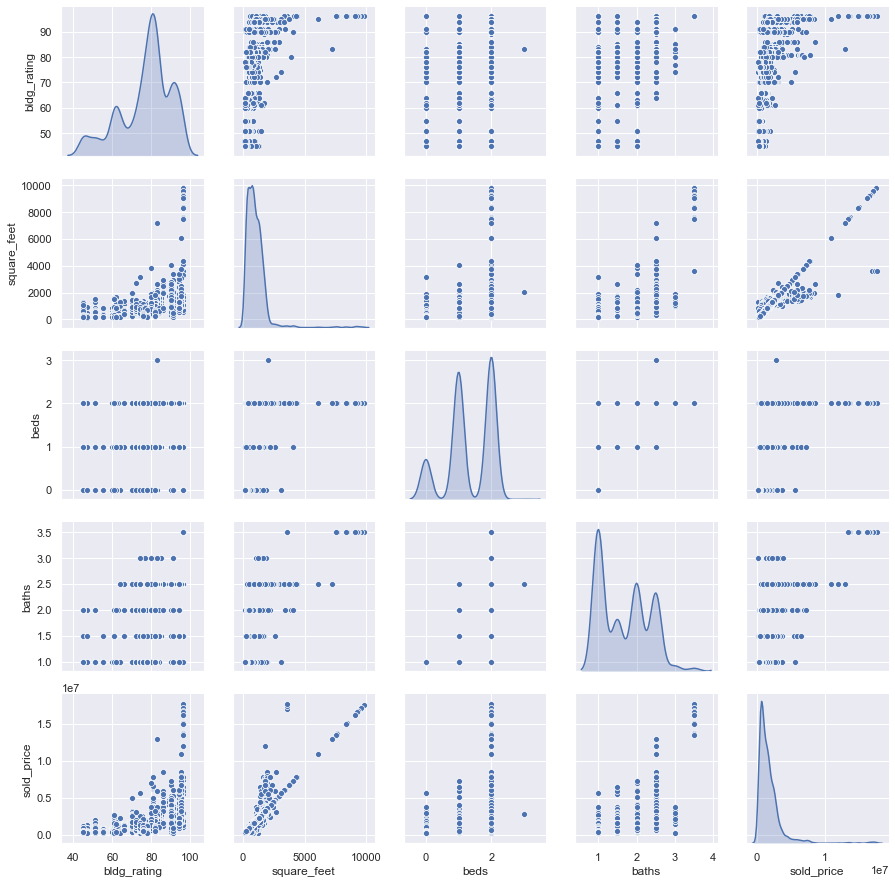

In [699]:
import seaborn as sns
%matplotlib inline
sns.set()
sns.pairplot(smaller_df, diag_kind='kde')

In [700]:
smaller_df.corr()

,bldg_rating,square_feet,beds,baths,sold_price
bldg_rating,1.000000,0.418541,0.279038,0.467157,0.449774
square_feet,0.418541,1.000000,0.462570,0.638309,0.902368
beds,0.279038,0.462570,1.000000,0.786187,0.427378
baths,0.467157,0.638309,0.786187,1.000000,0.623855
sold_price,0.449774,0.902368,0.427378,0.623855,1.000000


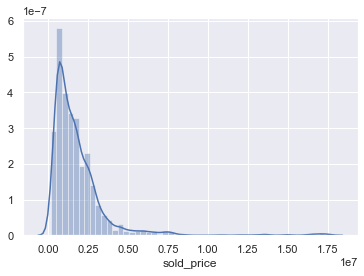

In [701]:
sns.distplot(smaller_df['sold_price'])

In [702]:
categorical = ['sold_season']
continuous = ['bldg_rating', 'square_feet', 'beds', 'baths']

smaller_df = pd.get_dummies(smaller_df)
smaller_df.head()

,bldg_rating,square_feet,beds,baths,sold_price,sold_season_Fall,sold_season_Spring,sold_season_Summer,sold_season_Winter
0,78.0,650,1.0,1.0,799000.0,1,0,0,0
1,70.0,907,1.0,1.0,1739990.0,1,0,0,0
2,80.0,1441,2.0,2.5,1782000.0,1,0,0,0
3,62.0,1420,2.0,2.0,1800000.0,1,0,0,0
4,91.0,1209,2.0,2.0,2195000.0,1,0,0,0


# Model

In [689]:
# Necessary imports
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge #ordinary linear regression + w/ ridge regularization
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [690]:
smaller_df.head()

,bldg_rating,sold_season,square_feet,beds,baths,sold_price
0,78.0,Fall,650,1.0,1.0,799000.0
1,70.0,Fall,907,1.0,1.0,1739990.0
2,80.0,Fall,1441,2.0,2.5,1782000.0
3,62.0,Fall,1420,2.0,2.0,1800000.0
4,91.0,Fall,1209,2.0,2.0,2195000.0


In [703]:
target = ['sold_price']
categorical = ['sold_season']
continuous = ['bldg_rating', 'square_feet', 'beds', 'baths']

X = smaller_df.drop('sold_price', axis = 1)
y = smaller_df['sold_price']

In [704]:
# hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10)

In [720]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, shuffle=True, random_state = 1000)

lm = LinearRegression()

np.mean(cross_val_score(lm, X, y, # estimator, features, target
                cv=kf, # number of folds 
                scoring='r2')) # scoring metric


0.82855763584414

In [721]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

lm_reg = Ridge(alpha=1)

np.mean(cross_val_score(lm_reg, X, y, cv=kf, scoring = 'r2'))
#mean(cross_val_score)

0.8285620865463255